In [1]:
%load_ext autoreload
%autoreload 2
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import choice
from collections import defaultdict, Counter
from analysis_utils import get_data
from learning_utils import pickle_load, pickle_save, construct_pipeline, Participant, get_normalized_features,\
                            get_normalized_feature_values, construct_reward_function, reward_levels, reward_type, \
                            construct_repeated_pipeline, create_dir, get_strategy_counts, get_cluster_dict, \
                            get_modified_weights
from sequence_utils import compute_average_click_likelihoods
from generic_mouselab import GenericMouselabEnv
from modified_mouselab import TrialSequence, reward_val, normal_reward_val, constant_reward_val, decreasing_reward_val
from planning_strategies import strategy_dict
from rl_models import models as rl_models
from computational_microscope import ComputationalMicroscope
from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare
from scipy.stats import ttest_ind, pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy.linalg as LA
from scipy.special import softmax
from IPython.core.display import display, HTML
from experiment_utils import Experiment
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["axes.grid"] = False

//anaconda3/envs/cogtut/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
import json
import random
trials = json.load(open("31123_increasing1.json", "rb"))
new_trials = []
for trial in trials:
    k = trial.copy()
    k["numClicks"] = random.randint(1, 10)
    new_trials.append(k)
print(new_trials)
json.dump(new_trials, open("31123_max_clicks.json", "w"))

[{'trial_id': 3656281603793530286, 'stateRewards': [0.0, 2.0, -1.0, -2.0, -9.0, 28.0, -74.0, 56.0, -6.0, 10.0, -8.0, 47.0, -2.0, -1.0, -2.0, 9.0, -35.0, -6.0, -28.0, 0.0, 19.0, -35.0, 37.0, 1.0, 1.0, 4.0, -5.0, -4.0, -30.0, -9.0, 4.0, -22.0, -13.0, -22.0], 'numClicks': 8}, {'trial_id': -8141988675068219020, 'stateRewards': [0.0, -1.0, -1.0, -0.0, -9.0, 8.0, 53.0, 24.0, -2.0, -28.0, -24.0, 54.0, 0.0, -1.0, 1.0, 17.0, 4.0, 20.0, 10.0, -3.0, -37.0, -11.0, -7.0, 1.0, 2.0, 4.0, 2.0, 28.0, -24.0, 40.0, 4.0, -10.0, 16.0, -2.0], 'numClicks': 10}, {'trial_id': -6934448659842275024, 'stateRewards': [0.0, 1.0, 3.0, 9.0, -11.0, -46.0, -16.0, 5.0, 7.0, 10.0, -65.0, -10.0, 1.0, 0.0, 3.0, -2.0, -6.0, 6.0, 13.0, 2.0, 4.0, -21.0, 12.0, 0.0, 2.0, 5.0, 1.0, -12.0, -20.0, 14.0, 1.0, -11.0, 1.0, -20.0], 'numClicks': 6}, {'trial_id': -8482891825638606048, 'stateRewards': [0.0, 1.0, -1.0, 5.0, 3.0, 19.0, -35.0, 5.0, 6.0, -31.0, -9.0, 1.0, -1.0, 1.0, 3.0, -7.0, 11.0, -42.0, -1.0, -13.0, 36.0, 13.0, -1.0, -1.0

In [2]:
def get_ds_weights(weights, features, feature_systems, decision_systems):
    ds_weights = defaultdict(int)
    for (f, w) in zip(features, weights):
        if feature_systems[f] == 'stopping_criteria' or f == "soft_pruning" or f == "termination_constant" or f=="is_previous_successor_negative":
            ds_weights[feature_systems[f]] += -w
        else:
            ds_weights[feature_systems[f]] += w
    return [ds_weights[ds] for ds in decision_systems]

def get_W_DS(W, features, feature_systems, decision_systems):
    num_strategies = W.shape[0]
    W_DS = []
    for i in range(num_strategies):
        W_DS.append(get_ds_weights(W[i], features, feature_systems, decision_systems))
    W_DS = np.array(W_DS)
    return W_DS

def get_ds_proportions(W_DS):
    DS_proportions = np.zeros_like(W_DS)
    for i in range(DS_proportions.shape[0]):
        total_w = np.sum([abs(w) for w in W_DS[i]])
        if total_w != 0:
            DS_proportions[i] = abs(W_DS[i])/total_w
    return DS_proportions

### Verifying which model wins the most for all distances

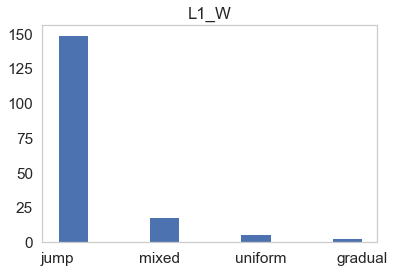

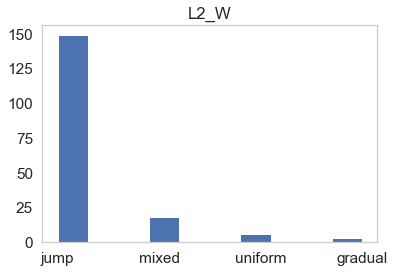

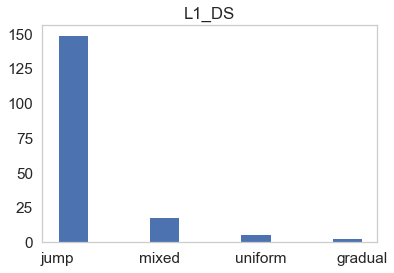

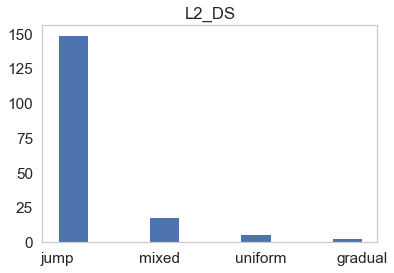

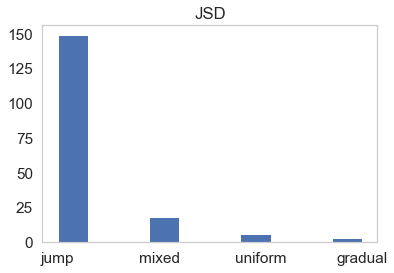

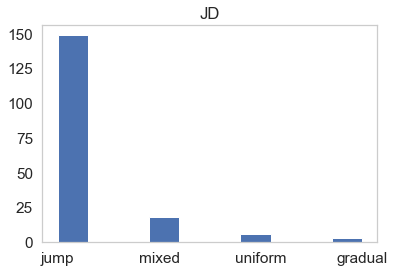

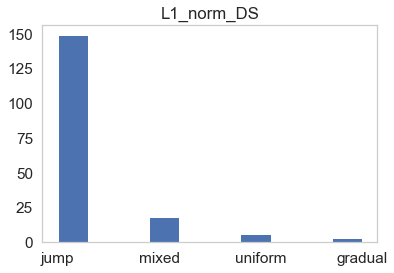

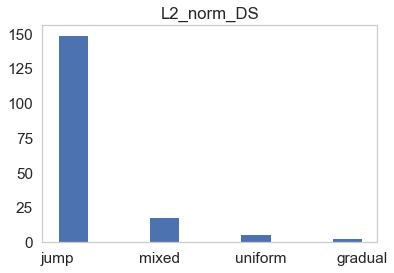

In [4]:
prior_transitions_v1 = pickle_load("data/prior_transitions_v1.pkl")
distances = ["L1_W", "L2_W", "L1_DS", "L2_DS", "JSD", "JD", "L1_norm_DS", "L2_norm_DS"]
distance_models = {}
for distance in distances:
    models = []
    for k in prior_transitions_v1[distance].keys():
        seq, T, transition_T, model = prior_transitions_v1[distance][k]
        models.append(model)
    distance_models[distance] = models
for distance in distances:
    plt.figure()
    plt.title(distance)
    plt.hist(models)

In [5]:
features = pickle_load("data/microscope_features.pkl")

decision_systems = pickle_load("data/decision_systems.pkl")
feature_systems = pickle_load("data/feature_systems.pkl")
decision_system_features = pickle_load("data/decision_system_features.pkl")

DS_proportions = pickle_load("data/strategy_decision_proportions.pkl")
W_DS = pickle_load("data/strategy_decision_weights.pkl")

strategy_weights = pickle_load("data/microscope_weights.pkl")

L1_DS = pickle_load("data/L1_DS.pkl")
L2_DS = pickle_load("data/L2_DS.pkl")
L1_norm_DS = pickle_load("data/L1_norm_DS.pkl")
L2_norm_DS = pickle_load("data/L2_norm_DS.pkl")

L1_distances = pickle_load("data/L1_distances.pkl")
L2_distances = pickle_load("data/L2_distances.pkl")
jeffreys_divergence = pickle_load("data/jeffreys_divergences.pkl")
jsd = pickle_load("data/js_divergences.pkl")

strategy_space = pickle_load("data/strategy_space.pkl")
num_strategies = len(strategy_space)
strategy_feature_scores = pickle_load("data/strategy_feature_scores.pkl") # Average scores using feature based representation of the strategies
strategy_scores = pickle_load("data/strategy_scores.pkl") # Average scores using an algorithmic representation of the strategies

clusters = pickle_load("data/kl_clusters.pkl")
cluster_map = pickle_load("data/kl_cluster_map.pkl")

cluster_scores = pickle_load("data/cluster_scores.pkl")

In [6]:
decision_systems = ['mental_effort_avoidance', 'model-based_metareasoning', 'model-free_values_and_heuristics', 'pavlovian', 'satisficing_and_stopping']
pickle_save(decision_systems, "data/decision_systems.pkl")

In [7]:
for f in ['hs_0.0', 'hs_16.0', "hs_24.0", "hs_32.0", "hs_40.0", "hs_48.0", "hs_8.0", "are_max_paths_observed", "is_max_path_observed", 
                "is_positive_observed", "is_previous_max", "single_path_completion", "all_leaf_nodes_observed", 
               "all_roots_observed", "positive_root_leaves_termination", "soft_satisficing"]:
    feature_systems[f] = 'satisficing_and_stopping'
print(feature_systems)
pickle_save(feature_systems, "data/feature_systems.pkl")

{'best_expected': 'pavlovian', 'best_largest': 'pavlovian', 'max_successor': 'pavlovian', 'max_expected_return': 'pavlovian', 'most_promising': 'pavlovian', 'is_successor_highest': 'pavlovian', 'hp_-24': 'pavlovian', 'hp_-48': 'pavlovian', 'hp_-8': 'pavlovian', 'hp_0': 'pavlovian', 'soft_pruning': 'pavlovian', 'is_previous_successor_negative': 'pavlovian', 'soft_satisficing': 'satisficing_and_stopping', 'hs_0.0': 'satisficing_and_stopping', 'hs_16.0': 'satisficing_and_stopping', 'hs_24.0': 'satisficing_and_stopping', 'hs_32.0': 'satisficing_and_stopping', 'hs_40.0': 'satisficing_and_stopping', 'hs_48.0': 'satisficing_and_stopping', 'hs_8.0': 'satisficing_and_stopping', 'max_uncertainty': 'model-based_metareasoning', 'successor_uncertainty': 'model-based_metareasoning', 'trial_level_std': 'model-based_metareasoning', 'uncertainty': 'model-based_metareasoning', 'get_level_observed_std': 'model-based_metareasoning', 'depth': 'model-free_values_and_heuristics', 'is_leaf': 'model-free_value

In [8]:
decision_system_features = defaultdict(list)
for k, v in feature_systems.items():
    decision_system_features[v].append(k)
decision_system_features = dict(decision_system_features)
print(decision_system_features)
pickle_save(decision_system_features, "data/decision_system_features.pkl")

{'pavlovian': ['best_expected', 'best_largest', 'max_successor', 'max_expected_return', 'most_promising', 'is_successor_highest', 'hp_-24', 'hp_-48', 'hp_-8', 'hp_0', 'soft_pruning', 'is_previous_successor_negative', 'immediate_successor_count', 'parent_value'], 'satisficing_and_stopping': ['soft_satisficing', 'hs_0.0', 'hs_16.0', 'hs_24.0', 'hs_32.0', 'hs_40.0', 'hs_48.0', 'hs_8.0', 'is_positive_observed', 'all_leaf_nodes_observed', 'all_roots_observed', 'are_max_paths_observed', 'is_max_path_observed', 'single_path_completion', 'is_previous_max', 'positive_root_leaves_termination'], 'model-based_metareasoning': ['max_uncertainty', 'successor_uncertainty', 'trial_level_std', 'uncertainty', 'get_level_observed_std', 'second_most_promising'], 'model-free_values_and_heuristics': ['depth', 'is_leaf', 'is_root', 'observed_height', 'ancestor_count', 'is_pos_ancestor_leaf', 'parent_observed', 'sq_successor_count', 'successor_count', 'siblings_count', 'previous_observed_successor', 'max_immed

In [ ]:
W_DS = get_W_DS(strategy_weights, features, feature_systems, decision_systems)
DS_proportions = get_ds_proportions(W_DS)
pickle_save(W_DS, "data/strategy_decision_weights.pkl")
pickle_save(DS_proportions, "data/strategy_decision_proportions.pkl")

In [ ]:
print(strategy_space)

In [ ]:
f = features.index('termination_constant')
count = 0
for s in strategy_space:
    if strategy_weights[s-1][0] != 0:
        print(s)
        count += 1

In [ ]:
print(clusters)
cluster_dict = defaultdict(list)
for i, c in enumerate(clusters):
    cluster_dict[c].append(strategy_space[i])
for c in sorted(cluster_dict.keys()):
    print(cluster_dict[c])

In [ ]:
print(cluster_scores)

In [ ]:
print(strategy_scores)
sns.distplot(list(strategy_scores.values()))

In [ ]:
l = [s for s in range(1, 90) if s not in strategy_space]
print(l, len(l))

In [ ]:
W_DS = get_W_DS(strategy_weights, features, feature_systems, decision_systems)
DS_proportions = get_ds_proportions(W_DS)

### Partitioning the set of strategies into quartiles according a decision system

In [10]:
from scipy.stats.mstats import mquantiles
temp_DS_proportions = DS_proportions[[s-1 for s in strategy_space], :]
decision_proportion_df = pd.DataFrame(temp_DS_proportions, columns = decision_systems)
pd.options.display.max_rows = 1000
decision_quantiles = decision_proportion_df.quantile([0.33, 0.67], axis = 0)
max_proportions = decision_proportion_df.max()
strategies_by_level = {}
for ds in decision_systems:
    df = decision_proportion_df[ds].tolist()
    qs = mquantiles(df, prob=[0.33, 0.67])
    vals = [*qs, max_proportions[ds]]
    level_indices = [0]
    for i in range(0, len(vals) - 1):
        if vals[i] != vals[i+1]:
            level_indices.append(i+1)
    min_val = -1
    total_partitions = []
    for i in level_indices:
        partition = []
        max_val = vals[i]
        for s, val in enumerate(df):
            if val > min_val and val <= max_val:
                partition.append(strategy_space[s])
        total_partitions.append(partition)
        min_val = max_val
    strategies_by_level[ds] = total_partitions

In [11]:
print(strategies_by_level)

{'mental_effort_avoidance': [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 78, 80, 82, 85, 86, 87, 88, 89], [1, 18, 30, 45, 66, 76, 79, 84]], 'model-based_metareasoning': [[2, 5, 6, 7, 8, 9, 11, 12, 13, 15, 18, 23, 24, 30, 31, 33, 36, 37, 39, 42, 48, 49, 54, 61, 62, 63, 64, 67, 69, 71, 74, 75, 76, 78, 79, 80, 87], [16, 27, 28, 40, 41, 44, 45, 46, 47, 60, 65, 66, 84, 86, 88, 89], [1, 3, 4, 10, 14, 17, 21, 22, 26, 29, 32, 34, 43, 50, 51, 53, 55, 56, 57, 58, 59, 70, 72, 73, 82, 85]], 'model-free_values_and_heuristics': [[1, 3, 14, 16, 17, 18, 21, 22, 26, 29, 30, 33, 39, 47, 49, 51, 53, 55, 62, 65, 67, 76, 80, 82, 85, 88], [4, 5, 10, 11, 15, 23, 31, 32, 34, 36, 37, 40, 42, 43, 45, 50, 56, 58, 59, 60, 63, 64, 70, 73, 75, 84, 89], [2, 6, 7, 8, 9, 12, 13, 24, 27, 28, 41, 44, 46, 48, 54, 57, 61, 66

### Validation of decision systems

In [12]:
print(decision_systems)

['mental_effort_avoidance', 'model-based_metareasoning', 'model-free_values_and_heuristics', 'pavlovian', 'satisficing_and_stopping']


In [13]:
ds_validation_sequences = defaultdict(lambda: defaultdict(list))
for trend in trends:
    for decision_system_index in range(len(decision_systems)):
        for run_num in range(num_seq):
            ds_validation_sequences[decision_system_index][trend].append(pickle_load(f"results/decision_system_validation/{decision_system_index}_{trend}_{run_num}.pkl"))

NameError: name 'trends' is not defined

In [14]:
from learning_utils import smoothen
#ds_validation_sequences = pickle_load("data/ds_validation_sequences.pkl")
trends = ["inc", "dec", "const"]
trend_labels = ["Increasing", "Decreasing", "Constant"]
num_seq = 500
num_decision_systems = len(decision_systems)
trend_inferred = defaultdict(lambda: defaultdict(list))
trend_actual = defaultdict(lambda: defaultdict(list))
for trend in trends:
    for decision_system_index in range(len(decision_systems)):
        for run_num in range(num_seq):
            inferred, actual = ds_validation_sequences[decision_system_index][trend][run_num]
            ds_validation_sequences[decision_system_index][trend].append((inferred, actual))
            inferred_props = [DS_proportions[s-1][decision_system_index] for s in inferred]
            actual_props = [DS_proportions[s-1][decision_system_index] for s in actual]
            trend_inferred[trend][decision_systems[decision_system_index]].append(inferred_props)
            trend_actual[trend][decision_systems[decision_system_index]].append(actual_props)
for trend in trends:
    for decision_system in decision_systems:
        trend_inferred[trend][decision_system] = np.mean(trend_inferred[trend][decision_system], axis = 0)
        trend_actual[trend][decision_system] = np.mean(trend_actual[trend][decision_system], axis = 0)
        
decision_system_labels = ["Mental effort avoidance", "Model-based Metareasoning", "Model-free values and heuristics",
                                "Pavlovian", "Satisficing and stopping"]
create_dir("results/decision_system_validation_plots")
figure_size = (9, 6)
for trend_index, trend in enumerate(trends):
    plt.figure(figsize = figure_size)
    for index, decision_system in enumerate(decision_systems):
        y = smoothen(trend_inferred[trend][decision_system]) # Change this later if smoothening is not required
        #y = trend_inferred[trend][decision_system]
        plt.plot(range(1, len(y) + 1), y, label = decision_system_labels[index])
    #plt.title(trend_labels[trend_index])
    plt.xlabel("Trial Number", fontsize=20)
    #plt.ylabel("Relative Influence of decision system", fontsize=20)
    plt.ylim(top = 1.2)
    plt.legend()
    plt.savefig(f"results/decision_system_validation_plots/{trend}_inferred.pdf", bbox_inches='tight')
print(figure_size)
for trend_index, trend in enumerate(trends):
    plt.figure(figsize = figure_size)
    for index, decision_system in enumerate(decision_systems):
        y = smoothen(trend_actual[trend][decision_system]) # Change this later if smoothening is not required
        #y = trend_actual[trend][decision_system]
        plt.plot(range(1, len(y) + 1), y, label = decision_system_labels[index])
    #plt.title(trend_labels[trend_index])
    plt.xlabel("Trial Number", fontsize=20)
    plt.ylabel("Relative Influence of decision system", fontsize=20)
    plt.ylim(top = 1.2)
    plt.legend()
    plt.savefig(f"results/decision_system_validation_plots/{trend}_actual.pdf", bbox_inches='tight')

IndexError: list index out of range

### Cluster wise decision system representation

In [15]:
cluster_DS_props = defaultdict(list)
for i, cluster in enumerate(clusters):
    cluster_DS_props[cluster].append(DS_proportions[strategy_space[i]-1])
threshold = 0.75
for cluster in sorted(cluster_DS_props.keys()):
    print(cluster)
    m = np.mean(cluster_DS_props[cluster], axis=0)
    sorted_m_indices = np.argsort(m)[::-1]
    sorted_m = np.sort(m)[::-1]
    sum_sorted_m = np.cumsum(sorted_m)
    print(sorted_m)
    for i, sm in enumerate(sum_sorted_m):
        if sm > threshold:
            break
    print([decision_systems[j] for j in sorted_m_indices[:i+1]])

1
[0.60380969 0.22206474 0.11076771 0.06335786 0.        ]
['model-free_values_and_heuristics', 'pavlovian']
2
[0.77940803 0.20138408 0.01920789 0.         0.        ]
['model-based_metareasoning']
3
[0.73898369 0.26101631 0.         0.         0.        ]
['model-free_values_and_heuristics', 'model-based_metareasoning']
4
[0.69907189 0.20985574 0.07065604 0.02041632 0.        ]
['model-free_values_and_heuristics', 'pavlovian']
5
[0.65384195 0.13371594 0.12374508 0.06110691 0.02759012]
['model-free_values_and_heuristics', 'satisficing_and_stopping']
6
[0.62716976 0.37283024 0.         0.         0.        ]
['model-free_values_and_heuristics', 'pavlovian']
7
[0.52296826 0.26780618 0.16147323 0.03283021 0.01492211]
['model-free_values_and_heuristics', 'mental_effort_avoidance']
8
[0.44284565 0.24007453 0.1655349  0.15154493 0.        ]
['model-free_values_and_heuristics', 'model-based_metareasoning', 'pavlovian']
9
[0.50749946 0.21813639 0.14163997 0.13272419 0.        ]
['model-free_va

### Validation

In [16]:
def get_standard_error(vals):
    std = np.std(vals)
    return np.round(std/np.sqrt(len(vals)), 3)

In [17]:
def get_confusion(s_true, s_pred):
    unique_true_s = np.unique(s_true + s_pred)
    unique_true_s.sort()
    num_unique = unique_true_s.shape[0]
    s_index = {s:i for i,s in enumerate(unique_true_s)}
    confusion_matrix = np.zeros((num_unique, num_unique))
    for t,p in zip(s_true, s_pred):
        confusion_matrix[s_index[t]][s_index[p]] += 1
    return confusion_matrix

def get_accuracy(confusion_matrix):
    counts = []
    total_count = np.sum(confusion_matrix)
    for k in range(confusion_matrix.shape[0]):
        counts.append(confusion_matrix[k][k])
    return np.round(np.sum(counts)/total_count, 3)
        
def get_confusions(s_true, s_pred, cluster_map):
    strategy_confusion = get_confusion(s_true, s_pred)
    c_true = [cluster_map[s+1] for s in s_true]
    c_pred = [cluster_map[s+1] for s in s_pred]
    cluster_confusion = get_confusion(c_true, c_pred)
    return strategy_confusion, cluster_confusion

In [18]:
def get_proportion_confusion(confusion_matrix, strategy_space): # We need inferred wrt true
    num_categories = confusion_matrix.shape[0]
    proportion_confusion = {}
    for i in range(num_categories):
        num_counts = confusion_matrix[:, i]
        num_counts = num_counts/num_counts.sum()
        proportion_confusion[strategy_space[i]] = {strategy_space[j]:np.round(c,3) for j,c in enumerate(num_counts)}
    return proportion_confusion

#### Mechanisms

In [19]:
def compute_average_confusion_index(strategy_confusion):
    indexes = []
    modified_jd = jeffreys_divergence[[s-1 for s in strategy_space], :]
    for i in range(strategy_confusion.shape[0]):
        for j in range(strategy_confusion.shape[1]):
            C = strategy_confusion[i][j] 
            if i!=j and C!=0:
                x = np.sort(modified_jd[i]).tolist()
                #print(x)
                index = x.index(modified_jd[i][j])
                #print(modified_jd[i][j], index, C)
                indexes += [index]*int(C)
    #plt.hist(indexes)
    print(np.mean(indexes), np.median(indexes))

In [20]:
def get_proportion_se(p, n):
    return np.sqrt(p*(1-p)/n)

In [21]:
strategy_validation_sequences = pickle_load("data/strategy_validation_sequences.pkl")
models = ["random", "random_switch", "gradual", "mixed", "bernoulli_rssl"]
distance = "L2_W"
num_seq = 500
TRUE_S = []
INFERRED_S = []
for model in models:
    total_accs = []
    true_s = []
    inferred_s = []
    for i in range(num_seq):
        acc, data = strategy_validation_sequences[model][distance][i]
        strategy_validation_sequences[model][distance].append((acc, data))
        true = data[0]['s']
        inferred = data[0]['inferred']
        total_accs.append(acc)
        true_s += true
        inferred_s += inferred
        TRUE_S += true
        INFERRED_S += inferred
    num_trials = len(inferred_s)
    strategy_confusion, cluster_confusion = get_confusions(true_s, inferred_s, cluster_map)
    proportion_strategy_confusion = get_proportion_confusion(strategy_confusion, strategy_space)
    proportion_cluster_confusion = get_proportion_confusion(cluster_confusion, range(1, len(clusters)+1))
    print(model)#, np.round(np.mean(total_accs), 3), get_standard_error(total_accs))
    strategy_acc = get_accuracy(strategy_confusion)
    print("Strategy Accuracy", strategy_acc)
    print("Strategy Accuracy standard error", np.round(1.96*get_proportion_se(strategy_acc, num_trials),3))
    cluster_strategy_acc = get_accuracy(cluster_confusion)
    compute_average_confusion_index(strategy_confusion)
    print("Cluster Accuracy", cluster_strategy_acc)
    print("Cluster Accuracy standard error", np.round(1.96*get_proportion_se(cluster_strategy_acc, num_trials), 3), "\n")
    
strategy_confusion, cluster_confusion = get_confusions(TRUE_S, INFERRED_S, cluster_map)
proportion_strategy_confusion = get_proportion_confusion(strategy_confusion, strategy_space)
proportion_cluster_confusion = get_proportion_confusion(cluster_confusion, range(1, len(clusters)+1))
strategy_acc = get_accuracy(strategy_confusion)
print("Strategy Accuracy", strategy_acc)
print("Strategy Accuracy standard error", np.round(1.96*get_proportion_se(strategy_acc, num_trials),3))
cluster_strategy_acc = get_accuracy(cluster_confusion)
compute_average_confusion_index(strategy_confusion)
print("Cluster Accuracy", cluster_strategy_acc)
print("Cluster Accuracy standard error", np.round(1.96*get_proportion_se(cluster_strategy_acc, num_trials), 3), "\n")

random
Strategy Accuracy 0.757
Strategy Accuracy standard error 0.007
34.822546419098146 35.0
Cluster Accuracy 0.909
Cluster Accuracy standard error 0.005 

random_switch
Strategy Accuracy 0.88
Strategy Accuracy standard error 0.005
32.59989229940765 32.0
Cluster Accuracy 0.962
Cluster Accuracy standard error 0.003 

gradual
Strategy Accuracy 0.769
Strategy Accuracy standard error 0.007
35.19318816303741 35.0
Cluster Accuracy 0.912
Cluster Accuracy standard error 0.004 

mixed
Strategy Accuracy 0.823
Strategy Accuracy standard error 0.006
34.98615664845173 35.0
Cluster Accuracy 0.935
Cluster Accuracy standard error 0.004 

bernoulli_rssl
Strategy Accuracy 0.755
Strategy Accuracy standard error 0.007
34.48339483394834 34.0
Cluster Accuracy 0.904
Cluster Accuracy standard error 0.005 

Strategy Accuracy 0.797
Strategy Accuracy standard error 0.006
34.591567183134366 34.0
Cluster Accuracy 0.924
Cluster Accuracy standard error 0.004 



### Strategy inferences - In sequence.

In [22]:
same_strategy_validation = pickle_load("data/same_strategy_validation.pkl")
dir_path = "results/"
overall_accs = []
true_s = []
inferred_s = []
num_seq = 100
for strategy in strategy_space:
    total_accs = []
    d_path = f"{dir_path}/{strategy}"
    total_s = []
    for i in range(num_seq):
        acc, data = same_strategy_validation[strategy][i]
        same_strategy_validation[strategy].append((acc, data))
        inferred_s += [s['inferred'][0] for s in data]
        true_s += [strategy-1]*len(data)
        total_accs.append(acc)
strategy_confusion, cluster_confusion = get_confusions(true_s, inferred_s, cluster_map)
proportion_strategy_confusion = get_proportion_confusion(strategy_confusion, strategy_space)
proportion_cluster_confusion = get_proportion_confusion(cluster_confusion, range(1, len(clusters)+1))
pickle_save(proportion_strategy_confusion, f"data/strategy_confusions_strategy_only.pkl")
pickle_save(proportion_cluster_confusion, f"data/cluster_confusions_strategy_only.pkl")
print("Strategy Accuracy", get_accuracy(strategy_confusion))
compute_average_confusion_index(strategy_confusion)
print("Cluster Accuracy", get_accuracy(cluster_confusion), "\n")

Strategy Accuracy 0.74
34.2883295194508 34.0
Cluster Accuracy 0.897 



### Representative feature for each cluster

In [23]:
def get_cluster_feature_values(clusters, W):
    data = []
    for i, cluster in enumerate(clusters):
        for strategy in cluster:
            data.append([i] + W[strategy-1].tolist())
    return data

def get_cluster_feature_df(clusters, W, features):
    data = get_cluster_feature_values(clusters, W)
    return pd.DataFrame(data, columns=['Cluster'] + features)

def drop_nunique_columns(df):
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    df.drop(cols_to_drop, axis=1, inplace=True)
    
def get_stat_df(df):
    new_df = df.copy()
    # Base case
    if len(new_df) == 1:
        return 
    drop_nunique_columns(new_df)
    stat_df = pd.DataFrame()
    stat_df['mean'] = new_df.mean(axis=0)
    stat_df['std'] = new_df.std(axis=0)
    stat_df['mstd'] = stat_df['mean'].divide(stat_df['std'])
    stat_df['mstd'] = stat_df['mstd'].abs()
    return stat_df

In [24]:
num_clusters = np.unique(clusters).shape[0]
cluster_dict = get_cluster_dict(clusters, strategy_space)
data_df = get_cluster_feature_df([cluster_dict[v] for v in range(1, num_clusters+1)], strategy_weights, features)
for cluster_num in range(num_clusters):
    d = data_df[data_df['Cluster'] == cluster_num]
    stat_df = get_stat_df(d)
    if stat_df is not None:
        m = stat_df['mstd'].max()
        x = stat_df.loc[stat_df['mstd'].idxmax()]
        print(cluster_num, x.name, cluster_dict[cluster_num+1], len(cluster_dict[cluster_num+1]))

0 max_successor [1, 8, 9, 13] 4
1 successor_uncertainty [3, 10, 82] 3
3 siblings_count [5, 36, 37, 54, 79] 5
4 second_most_promising [4, 6, 7, 11, 12, 31, 45, 46, 47, 59, 60, 84] 12
6 uncertainty [28, 30, 34, 66] 4
7 is_root [22, 23, 32, 33, 53, 64, 65, 69, 70, 80] 10
8 successor_uncertainty [21, 40, 41, 43, 55, 56, 57, 58, 63, 67] 10
9 depth_count [16, 26, 27, 29, 44, 50, 61, 73, 78, 89] 10
12 depth [2, 14, 17, 18, 24, 39, 42, 48, 49, 62, 71, 74, 76, 85, 86, 87, 88] 17


### TODO:
1. Add clustering for decision system weights averaged for participants to see if we can get individual differences.

### Emperical data

In [25]:
features = pickle_load("data/microscope_features.pkl")
num_features = len(features)
exp_pipelines = pickle_load("data/exp_pipelines.pkl")
exp_reward_structures = {'v1.0': 'high_increasing', 'F1': 'high_increasing', 'c1.1': 'low_constant', 'T1.1': 'large_increasing'}

### For reference
v1.0 - feedback in ['action', 'meta', 'none']

F1 - condition in [0, 1, 2] which is ['action', 'meta', 'none']

c2.1 - variance in [2424, 2442]

### Excluding participants from the experiment c2.1

In [26]:
from analysis_utils import get_data
exp_data = get_data("c2.1")
pdf = exp_data['participants']
pdf = pdf.loc[pdf.completed].set_index('pid', drop=False)
if 'variance' in pdf:
    pdf.variance = pdf.variance.replace(2442, 'decreasing').replace(2424, 'increasing')
else:
    pdf['variance'] = 'constant'
print(f'{len(pdf)} participants')
complete = list(pdf.index)
def extract(q):
    return list(map(int, q['click']['state']['target']))
mdf = exp_data['mouselab-mdp'].set_index('pid', drop=False)
mdf = mdf.loc[complete]
mdf['clicks'] = mdf.queries.apply(extract)
mdf['n_clicks'] = mdf.clicks.apply(len)
mdf['variance'] = pdf['variance']

69 participants


In [27]:
def excluded_pids():
    sdf = exp_data['survey-multi-choice'].query('pid == @complete').set_index('pid')
    responses = pd.DataFrame(list(sdf.responses), index=sdf.index)
    grp = responses.groupby(lambda pid: pdf.variance[pid])
    correct = grp.apply(lambda x: x.mode().iloc[0])
    errors = correct.loc[pdf.variance].set_index(pdf.index) != responses
    fail_quiz = errors.sum(1) > 1
    no_click = mdf.query('block == "train_inspector"').n_clicks.groupby('pid').sum() == 0
    return fail_quiz | no_click
excluded = pdf[~excluded_pids()]
c2_pids = list(excluded.index)
df = pd.DataFrame.from_dict({"pids": c2_pids})
df.to_csv("../data/human/c2.1/pids.csv")

### Using the Experiment class

In [28]:
strategy_confusions = pickle_load("data/strategy_confusions_strategy_only.pkl")
cluster_confusions = pickle_load("data/cluster_confusions_strategy_only.pkl")

In [29]:
def get_E(exp_num, increasing=False, condition='', block=''):
    pids = None
    if exp_num == "T1.1":
        block = 'test'
    exp_data = get_data(exp_num)
    participants_df = exp_data['participants']
    if 'pids' in exp_data:
        pids = sorted(exp_data['pids']['pids'].tolist())
    else:
        pids = participants_df['pid'].tolist()
    trials_data = exp_data['mouselab-mdp']
    participant_conditions = {}
    if exp_num in ["c1.1", "c2.1"]:
        trials_data = trials_data[trials_data.block == "test"]
        if exp_num in "c2.1":
            conditions = participants_df[['pid', 'variance']]
            conditions.set_index('pid', inplace = True)
            participant_conditions = conditions.to_dict()['variance']
            increasing_pids = [pid for pid in participant_conditions.keys() if participant_conditions[pid] == 2424 and pid in pids]
            decreasing_pids = [pid for pid in participant_conditions.keys() if participant_conditions[pid] == 2442 and pid in pids]
    if not exp_num == "c2.1":
        if exp_num in ["A1.0", "A3.0"]:
            pipeline = exp_pipelines["F1"]
            reward_structure = exp_reward_structures['F1']
        else:
            pipeline = exp_pipelines[exp_num]
            reward_structure = exp_reward_structures[exp_num]
    else:
        if increasing:
            pipeline = exp_pipelines["c2.1_inc"]
            pids = increasing_pids
            reward_structure = 'high_increasing'
        else:
            pipeline = exp_pipelines["c2.1_dec"]
            pids = decreasing_pids
            reward_structure = 'high_decreasing'

    if condition or block:
        suffix = block + "_" + condition
    else:
        suffix = ""
    normalized_features = get_normalized_features(reward_structure)
    W = get_modified_weights(strategy_space, strategy_weights)
    pipeline = [pipeline[0]]*100
    cm = ComputationalMicroscope(pipeline, strategy_space, W, features, normalized_features=normalized_features)
    if condition:
        if exp_num == "v1.0":
            E = Experiment(exp_num, cm=cm, pids = pids, feedback=condition)
            if block:
                E = Experiment(exp_num, cm=cm, pids=pids, feedback=condition, block=block)
        else:
            E = Experiment(exp_num, cm=cm, pids=pids, condition=condition)
    else:
        E = Experiment(exp_num, cm=cm, pids=pids)
        if block:
            E = Experiment(exp_num, cm=cm, block=block, pids=pids)
    if block and not exp_num == "c2.1":
        try:
            strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_{block}_strategies.pkl")
        except Exception as e:
            return E, _, normalized_features, cm
    else:
        if exp_num == "c2.1":
            if increasing:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_inc_strategies.pkl")
                if block:
                    strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_inc_{block}_strategies.pkl")
                
            else:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_dec_strategies.pkl")
                if block:
                    strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_dec_{block}_strategies.pkl")
        else:
            try:
                strategies = pickle_load(f"results/final_strategy_inferences/{exp_num}_strategies.pkl")
            except:
                strategies = None
    return E, strategies, normalized_features

In [48]:
E, strategies, normalized_features, cm = get_E("v1.0", condition='none', block='training')
E.infer_strategies()

1
100%|██████████| 30/30 [00:24<00:00,  1.31it/s, best loss: 93.96870737547314]
[54, 54, 54, 54, 79, 79, 64, 64, 64, 64] 10.378865188875906
2
100%|██████████| 30/30 [00:10<00:00,  2.99it/s, best loss: 19.03612506434709]
[30, 30, 30, 30, 30, 30, 53, 53, 53, 53] 0.044659499173552414
5
100%|██████████| 30/30 [00:16<00:00,  1.85it/s, best loss: 72.86300954792716]
[54, 21, 21, 21, 21, 21, 21, 21, 21, 21] 21.014380202706167
11
100%|██████████| 30/30 [00:14<00:00,  2.08it/s, best loss: 82.50556522183645]
[22, 22, 22, 31, 31, 31, 31, 21, 21, 21] 19.64116308936122
12
100%|██████████| 30/30 [00:14<00:00,  2.05it/s, best loss: 79.99173943933656]
[70, 74, 74, 21, 21, 21, 21, 21, 21, 21] 21.00982401249367
14
100%|██████████| 30/30 [00:16<00:00,  1.89it/s, best loss: 76.71351003626339]
[22, 22, 31, 31, 31, 31, 31, 31, 31, 31] 11.627451754900132
15
100%|██████████| 30/30 [00:17<00:00,  1.77it/s, best loss: 90.57700861968394] 
[22, 22, 37, 31, 31, 31, 31, 31, 31, 31] 13.356377091702026
16
100%|███████

In [49]:
print(E.participant_strategies)

defaultdict(<class 'list'>, {1: [54, 54, 54, 54, 79, 79, 64, 64, 64, 64], 2: [30, 30, 30, 30, 30, 30, 53, 53, 53, 53], 5: [54, 21, 21, 21, 21, 21, 21, 21, 21, 21], 11: [22, 22, 22, 31, 31, 31, 31, 21, 21, 21], 12: [70, 74, 74, 21, 21, 21, 21, 21, 21, 21], 14: [22, 22, 31, 31, 31, 31, 31, 31, 31, 31], 15: [22, 22, 37, 31, 31, 31, 31, 31, 31, 31], 16: [30, 30, 30, 30, 30, 30, 30, 30, 54, 31], 25: [30, 30, 30, 63, 63, 63, 63, 63, 63, 63], 26: [87, 87, 78, 78, 78, 78, 78, 21, 21, 21], 30: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30], 32: [79, 79, 79, 79, 79, 65, 65, 65, 65, 65], 39: [22, 22, 22, 22, 22, 22, 22, 22, 22, 22], 41: [61, 61, 61, 11, 11, 11, 11, 11, 11, 11], 42: [84, 84, 29, 59, 59, 57, 57, 57, 57, 57], 43: [69, 76, 16, 16, 18, 16, 16, 16, 16, 16], 52: [53, 53, 53, 53, 53, 53, 53, 53, 53, 10], 56: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30], 57: [23, 30, 30, 23, 23, 23, 30, 30, 30, 30], 64: [30, 30, 30, 30, 37, 6, 6, 16, 39, 45], 68: [30, 30, 69, 45, 45, 45, 45, 45, 45, 45], 69: [49, 4

In [50]:
print(len(E.participant_strategies))

54


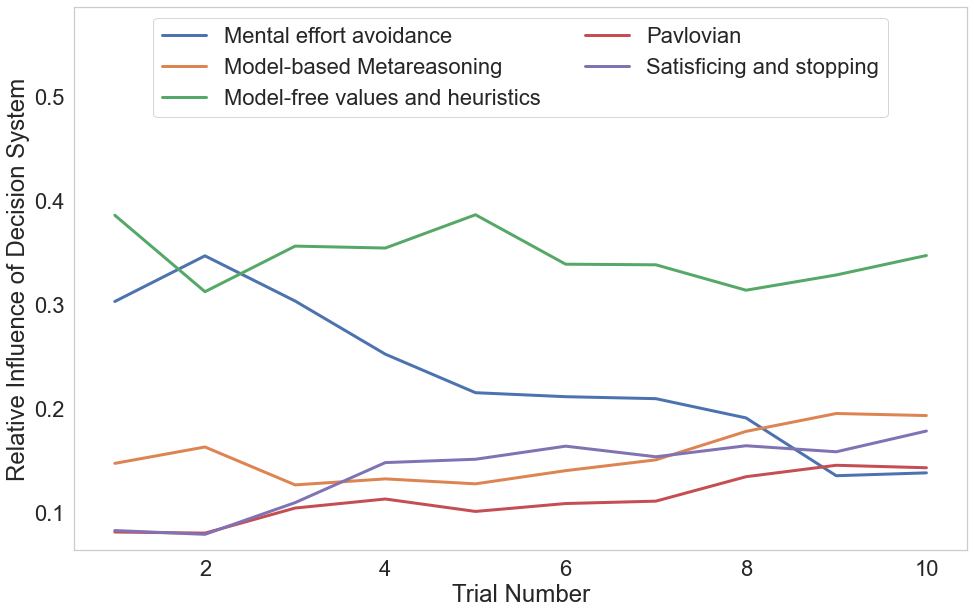

In [51]:
E.init_feature_properties(features, normalized_features, strategy_weights)
E.init_decision_system_properties(decision_systems, W_DS, DS_proportions)
E.plot_average_ds(suffix="v1_training")

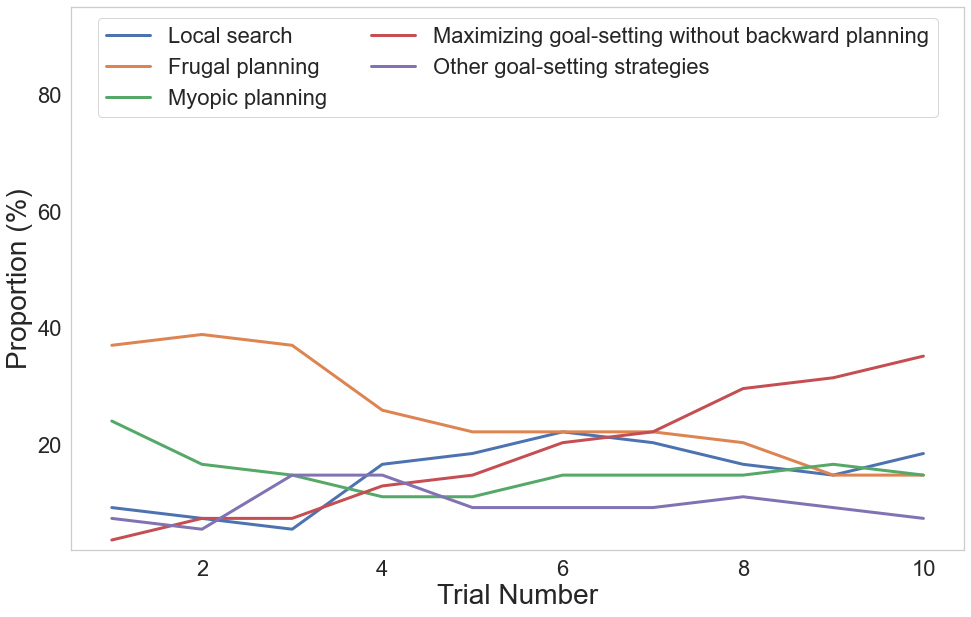

In [53]:
E.init_strategy_clusters(cluster_map)
clusters = [5, 7, 8, 9, 10]
labels = ["Local search", "Frugal planning", "Myopic planning", "Maximizing goal-setting without backward planning", "Other goal-setting strategies"]
E.plot_cluster_proportions(C=clusters, labels=labels)

[30, 21, 22, 31, 63]


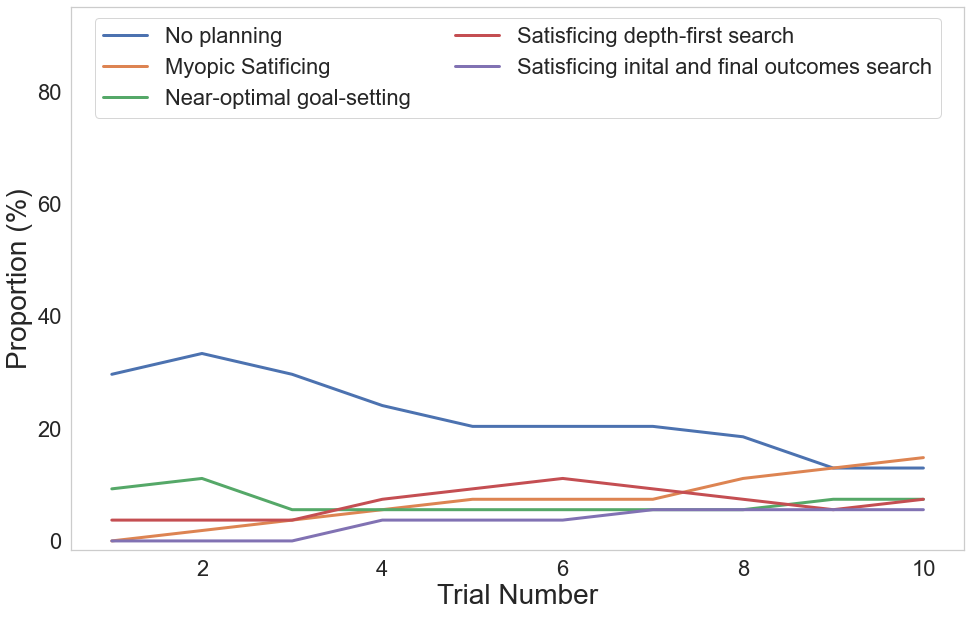

In [54]:
prop = E.get_strategy_proportions()
sorted_props = sorted(prop.items(), key=operator.itemgetter(1), reverse=True)[:5]
S = [p[0] for p in sorted_props]
print(S)
labels = ["No planning", "Myopic Satificing", "Near-optimal goal-setting", "Satisficing depth-first search", "Satisficing inital and final outcomes search"]
E.plot_strategy_proportions(S=S, labels=labels)

In [55]:
exp_num = "v1.0"
E, strategies, normalized_features = get_E(exp_num, increasing=False)

In [56]:
F1, F1_strategies, _ = get_E("F1")
v1, v1_strategies, _ = get_E("v1.0")
c1, c1_strategies, _ = get_E("c1.1", block='test')
c2_inc, c2_inc_strategies, _ = get_E("c2.1", increasing=True, block='test')
c2_dec, c2_dec_strategies, _ = get_E("c2.1", increasing=False, block='test')
T1, T1_strategies, _ = get_E("T1.1", block='test')

In [57]:
v1.infer_strategies(precomputed_strategies=v1_strategies)

0
1
2
3
4
5
6
7
Strategies for 7 not found. Skipping adding strategy data
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
Strategies for 28 not found. Skipping adding strategy data
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
Strategies for 45 not found. Skipping adding strategy data
46
Strategies for 46 not found. Skipping adding strategy data
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
Strategies for 72 not found. Skipping adding strategy data
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
Strategies for 89 not found. Skipping adding strategy data
90
91
92
93
95
Strategies for 95 not found. Skipping adding strategy data
96
97
Strategies for 97 not found. Skipping adding strategy data
98
99
100
101
102
104
Strategies for 104 not found. Skipping adding strategy data
105
106
107
Strategies for 107 not found. Skipping adding strategy data
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
129
130
131
13

In [58]:
def get_trajectory(S):
    tr = [S[0]]
    for s in S[1:]:
        if s!= tr[-1]:
            tr.append(s)
    return tuple(tr)

def get_trajectories(exp):
    trs = []
    count = 0
    for pid, S in exp.participant_strategies.items():
        #print(S)
        if S:
            count += 1
        trs.append(get_trajectory(S))
    sorted_counts = sorted(Counter(trs).items(), key=operator.itemgetter(1), reverse=True)
    #print(sorted_counts)
    #print(len(sorted_counts), count)
    return trs, sorted_counts

def get_cluster_trajectories(exp):
    trs = []
    count = 0
    for pid, S in exp.participant_strategies.items():
        #print(S)
        if S:
            count += 1
        cluster_S = [cluster_map[s] for s in S]
        trs.append(get_trajectory(cluster_S))
    sorted_counts = sorted(Counter(trs).items(), key=operator.itemgetter(1), reverse=True)
    #print(sorted_counts)
    #print(len(sorted_counts), count)
    return trs, sorted_counts

def get_lengths(trs):
    lengths = [len(tr[1:-1]) for tr in trs]
    print(np.mean(lengths))
    return lengths

In [59]:
trs, sorted_counts = get_trajectories(v1)
print(len(sorted_counts))

141


In [60]:
def print_props(counts):
    S = sum([p[1] for p in counts])
    props = [(p[0], p[1]/S) for p in counts]
    print("\n", props)

In [61]:
nofb_trs, nofb_sorted_counts = get_trajectories(v1_nofb)
c_nofb_trs, c_nofb_sorted_counts = get_cluster_trajectories(v1_nofb)
meta_trs, meta_sorrted_counts = get_trajectories(v1_meta)
c_meta_trs, c_meta_sorted_counts = get_cluster_trajectories(v1_meta)
action_trs, action_sorted_counts = get_trajectories(v1_action)
c_action_trs, c_action_sorted_counts = get_cluster_trajectories(v1_action)

print(nofb_sorted_counts)
print("\n")
print(meta_sorted_counts)
print("\n")
print(action_sorted_counts)
print("\n")
print("\n")
print(c_nofb_sorted_counts)
print_props(c_nofb_sorted_counts)
print("\n")
print(c_meta_sorted_counts)
print_props(c_meta_sorted_counts)
print("\n")
print(c_action_sorted_counts)
print_props(c_action_sorted_counts)
print("\n")
print("\n")
nofb_ls = get_lengths(nofb_trs)
meta_ls = get_lengths(meta_trs)
action_ls = get_lengths(action_trs)
print("\n")
c_nofb_ls = get_lengths(c_nofb_trs)
c_meta_ls = get_lengths(c_meta_trs)
c_action_ls = get_lengths(c_action_trs)

NameError: name 'v1_nofb' is not defined

In [ ]:
# MCFB vs No FB
t_test(meta_ls, nofb_ls)

# MCFB vs Action FB
t_test(meta_ls, action_ls)

# Action vs No FB
t_test(action_ls, nofb_ls)

print("\n")
# Cluster
# MCFB vs No FB
t_test(c_meta_ls, c_nofb_ls)

# MCFB vs Action FB
t_test(c_meta_ls, c_action_ls)

# Action vs No FB
t_test(c_action_ls, c_nofb_ls)

In [ ]:
def get_mean_score(v):
    scores = []
    for p in v.participants.values():
#         if p.condition == 0:
#             print(p.condition)
            scores.append(np.mean(p.score))
    print(len(scores))
    print(scores)
    print(np.mean(scores))
    print(np.std(scores))
    pass

exp_data = get_data(exp_num)
participants_df = exp_data['participants']
if 'pids' in exp_data:
    pids = sorted(exp_data['pids']['pids'].tolist())
else:
    pids = participants_df['pid'].tolist()
Fc = Experiment("v1.0", pids=pids, feedback='meta', block='test')
get_mean_score(Fc)

In [ ]:
print(len(c2_inc.pids))

### Condition-wise plots for Experiment v1

In [62]:
v1_meta, v1_meta_strategies, _ = get_E("v1.0", condition='meta')
v1_action, v1_action_strategies, _ = get_E("v1.0", condition='action')
v1_nofb, v1_nofb_strategies, _ = get_E("v1.0", condition='none')

In [63]:
def get_num_clicks(exp):
    num_clicks = []
    for pid in exp.pids:
        for click_sequence in exp.participants[pid].clicks:
            num_clicks.append(len(click_sequence)-1)
    print(np.mean(num_clicks))
    return num_clicks

In [64]:
def t_test(s1, s2):
    t, p = ttest_ind(s1, s2)
    df = len(s1) + len(s2) - 2
    print(f"t({df}): {np.round(t, 2)}, p: {np.round(p, 4)}")
    return t, p, df

### Testing number of clicks

In [65]:
meta_clicks = get_num_clicks(v1_meta)
action_clicks = get_num_clicks(v1_action)
nofb_clicks = get_num_clicks(v1_nofb)

t_test(nofb_clicks, action_clicks)
t_test(nofb_clicks, meta_clicks)

3.496969696969697
4.875757575757576
3.5858024691358024
t(3268): -10.52, p: 0.0
t(3268): 0.9, p: 0.3683


(0.8998561228439519, 0.36826312439094366, 3268)

In [66]:
print(decision_systems)

['mental_effort_avoidance', 'model-based_metareasoning', 'model-free_values_and_heuristics', 'pavlovian', 'satisficing_and_stopping']


### Testing if proportion of optimal strategy and no planning were different when compared across conditions

Strategies for 0 not found. Skipping adding strategy data
Strategies for 1 not found. Skipping adding strategy data
Strategies for 2 not found. Skipping adding strategy data
Strategies for 3 not found. Skipping adding strategy data
Strategies for 5 not found. Skipping adding strategy data
Strategies for 6 not found. Skipping adding strategy data
Strategies for 7 not found. Skipping adding strategy data
Strategies for 8 not found. Skipping adding strategy data
Strategies for 9 not found. Skipping adding strategy data
Strategies for 11 not found. Skipping adding strategy data
Strategies for 12 not found. Skipping adding strategy data
Strategies for 14 not found. Skipping adding strategy data
Strategies for 15 not found. Skipping adding strategy data
Strategies for 16 not found. Skipping adding strategy data
Strategies for 17 not found. Skipping adding strategy data
Strategies for 18 not found. Skipping adding strategy data
Strategies for 19 not found. Skipping adding strategy data
Strate

0.2351851851851852
0.1617283950617284
Strategies for 0 not found. Skipping adding strategy data
Strategies for 3 not found. Skipping adding strategy data
Strategies for 4 not found. Skipping adding strategy data
Strategies for 6 not found. Skipping adding strategy data
Strategies for 7 not found. Skipping adding strategy data
Strategies for 8 not found. Skipping adding strategy data
Strategies for 9 not found. Skipping adding strategy data
Strategies for 10 not found. Skipping adding strategy data
Strategies for 13 not found. Skipping adding strategy data
Strategies for 17 not found. Skipping adding strategy data
Strategies for 18 not found. Skipping adding strategy data
Strategies for 19 not found. Skipping adding strategy data
Strategies for 20 not found. Skipping adding strategy data
Strategies for 21 not found. Skipping adding strategy data
Strategies for 22 not found. Skipping adding strategy data
Strategies for 23 not found. Skipping adding strategy data
Strategies for 24 not fou

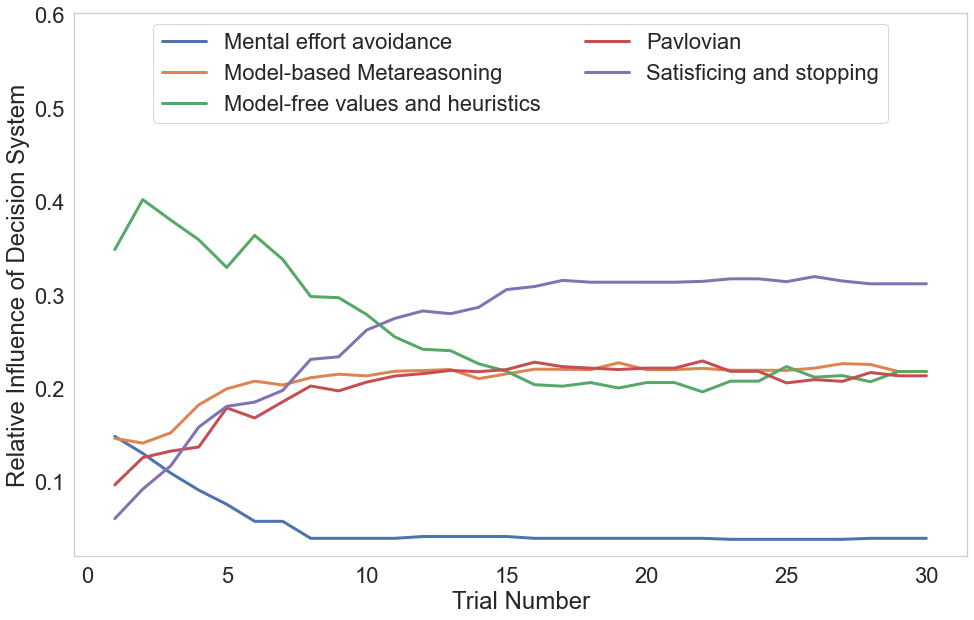

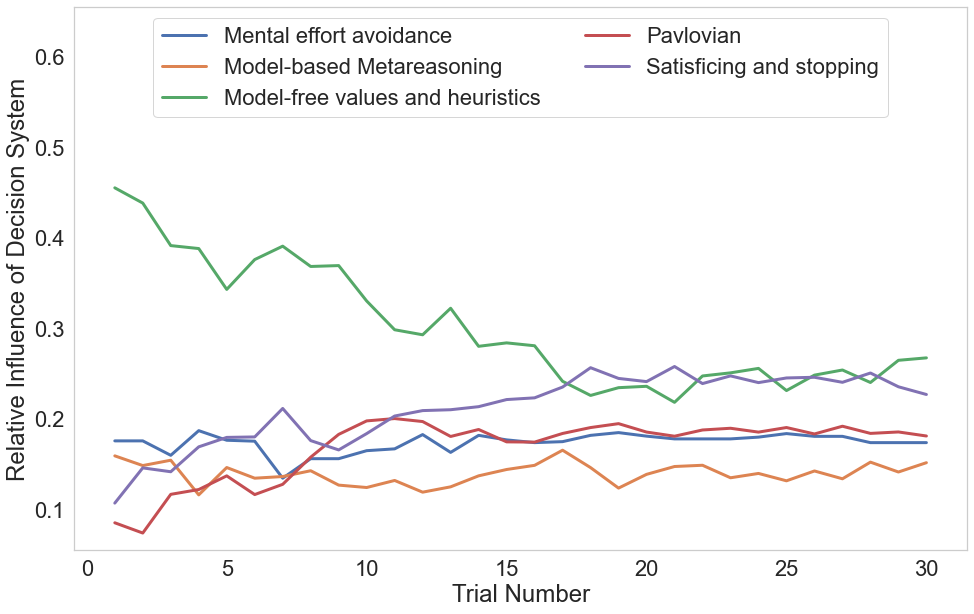

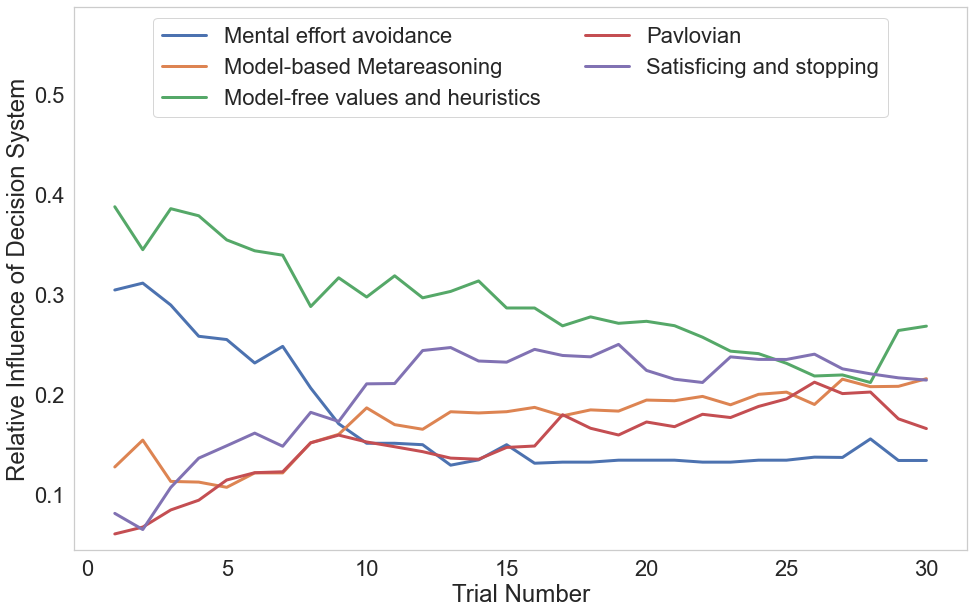

In [67]:
suffixes = ["meta", "action", "none"]
exp_s = [v1_meta_strategies, v1_action_strategies, v1_nofb_strategies]
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    exp.infer_strategies(precomputed_strategies = exp_s[i], show_pids=False)
    exp.init_decision_system_properties(decision_systems, W_DS, DS_proportions)
    exp.plot_average_ds(suffix = suffixes[i])
    mean_dsw = exp.get_mean_DSW()
    
    print(exp.get_strategy_proportions()[21])
    print(exp.get_strategy_proportions()[30])

In [68]:
def sort_counts(counts):
    sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_counts

In [69]:
k = 4
strategies_set = set()
for exp, S in zip([v1_meta, v1_action, v1_nofb], [v1_meta_strategies, v1_action_strategies, v1_nofb_strategies]):
    exp.infer_strategies(precomputed_strategies=S, show_pids=False)
    counts = exp.get_strategy_proportions()
    sorted_counts = sort_counts(counts)
    strategies_set = strategies_set.union({p[0] for p in sorted_counts[:k]})
sorted(list(strategies_set))

Strategies for 0 not found. Skipping adding strategy data
Strategies for 1 not found. Skipping adding strategy data
Strategies for 2 not found. Skipping adding strategy data
Strategies for 3 not found. Skipping adding strategy data
Strategies for 5 not found. Skipping adding strategy data
Strategies for 6 not found. Skipping adding strategy data
Strategies for 7 not found. Skipping adding strategy data
Strategies for 8 not found. Skipping adding strategy data
Strategies for 9 not found. Skipping adding strategy data
Strategies for 11 not found. Skipping adding strategy data
Strategies for 12 not found. Skipping adding strategy data
Strategies for 14 not found. Skipping adding strategy data
Strategies for 15 not found. Skipping adding strategy data
Strategies for 16 not found. Skipping adding strategy data
Strategies for 17 not found. Skipping adding strategy data
Strategies for 18 not found. Skipping adding strategy data
Strategies for 19 not found. Skipping adding strategy data
Strate

[21, 30, 31, 42, 57, 58]

In [70]:
condition_optimal_planning = []
condition_no_planning = []
total_num = []
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    trial_props, total_counts = exp.get_strategy_frequencies(exp.participant_strategies, trial_wise=True)
    num_time_steps = max(trial_props.keys())+1
    optimal_props = np.zeros(num_time_steps)
    no_planning_props = np.zeros(num_time_steps)
    for t in trial_props.keys():
        if 21 in trial_props[t]:
            optimal_props[t] = trial_props[t][21]
        no_planning_props[t] = trial_props[t][30]
    condition_optimal_planning.append(optimal_props)
    condition_no_planning.append(no_planning_props)
    total_num.append(total_counts)
print(np.array(condition_optimal_planning), np.array(condition_no_planning))
print(total_num)

[[ 4.  7. 11. 17. 21. 22. 24. 28. 29. 32. 34. 35. 34. 35. 38. 39. 40. 40.
  40. 40. 40. 40. 40. 40. 38. 37. 38. 37. 37. 37.]
 [ 0.  0.  0.  2.  3.  4.  7.  8.  9. 11. 12. 14. 15. 13. 13. 17. 17. 19.
  16. 15. 17. 18. 18. 18. 19. 19. 18. 21. 19. 19.]
 [ 1.  2.  3.  4.  4.  5.  5.  9. 10. 16. 18. 20. 19. 19. 22. 22. 21. 21.
  22. 24. 23. 23. 24. 23. 23. 24. 24. 24. 23. 23.]] [[ 8.  7.  6.  5.  4.  3.  3.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 9.  9.  8.  9.  9.  9.  7.  8.  8.  8.  8.  9.  8.  9.  9.  9.  9.  9.
   9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.]
 [16. 16. 15. 13. 13. 12. 13. 11.  9.  8.  8.  8.  7.  7.  8.  7.  7.  7.
   7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  7.  7.]]
[array([55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55.,
       55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55.,
       55., 55., 55., 55.]), array([54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
  

In [71]:
# Comparing time frequencies of two groups
from scipy.stats import chi2_contingency
# Comparing MCFB and No FB
g, p, dof, _ = chi2_contingency([condition_optimal_planning[0][-5:], condition_optimal_planning[2][-5:]])
print(np.round(g, 2), np.round(p,4), dof)
g, p, dof, _ = chi2_contingency([condition_no_planning[0], condition_no_planning[2]])
print(np.round(g, 2), np.round(p,4), dof)
g, p, dof, _ = chi2_contingency([condition_optimal_planning[1], condition_optimal_planning[2]])
print(np.round(g, 2), np.round(p,4), dof)
g, p, dof, _ = chi2_contingency([condition_no_planning[1], condition_no_planning[2]])
print(np.round(g, 2), np.round(p,4), dof)

0.03 0.9999 4
3.83 1.0 29
8.23 0.9999 29
14.14 0.9906 29


### Comparing the relative influence of decision trials in the first five trials versus the last five trials

(54, 30, 5)
0.006391150954545011
mental_effort_avoidance
t(106): 0.03, p: 0.9745
WilcoxonResult(statistic=100.0, pvalue=0.8507113997336977)
model-based_metareasoning
t(106): -0.37, p: 0.7105
WilcoxonResult(statistic=329.0, pvalue=0.39334061944148146)
model-free_values_and_heuristics
t(106): -3.76, p: 0.0003
WilcoxonResult(statistic=237.0, pvalue=0.0005391507694430498)
pavlovian
t(106): 3.73, p: 0.0003
WilcoxonResult(statistic=172.0, pvalue=0.0002770978498399949)
satisficing_and_stopping
t(106): 4.05, p: 0.0001
WilcoxonResult(statistic=122.0, pvalue=3.730858583996266e-05)


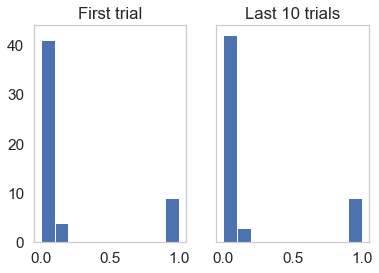

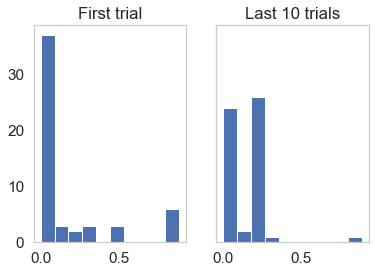

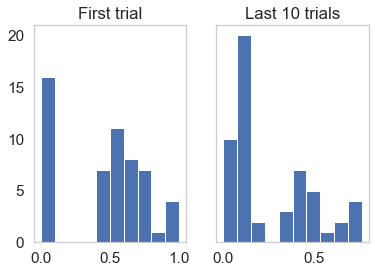

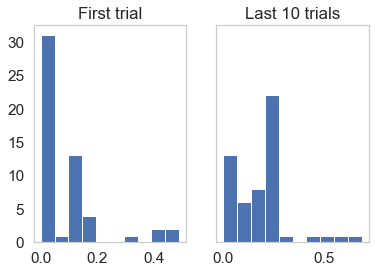

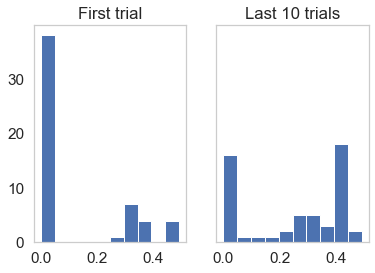

In [72]:
from scipy.stats import wilcoxon
DSW = v1_action.get_DSW()
DSW = np.array(DSW)
print(DSW.shape)
from learning_utils import sidak_value
alpha_sidak = sidak_value(0.05, 8)
print(alpha_sidak)
k = 5
for i in range(DSW.shape[-1]):
    print(decision_systems[i])
    x1 = np.mean(DSW[:, :1, i], axis=1)
    x2 = np.mean(DSW[:, -10:, i], axis=1)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    #f.suptitle(decision_systems[i])
    ax1.hist(x1)
    ax2.hist(x2)
    ax1.set_title("First trial")
    ax2.set_title("Last 10 trials")
    t_test(x2, x1)
    print(wilcoxon(x2, x1))

[21, 30, 31, 42, 57, 58]


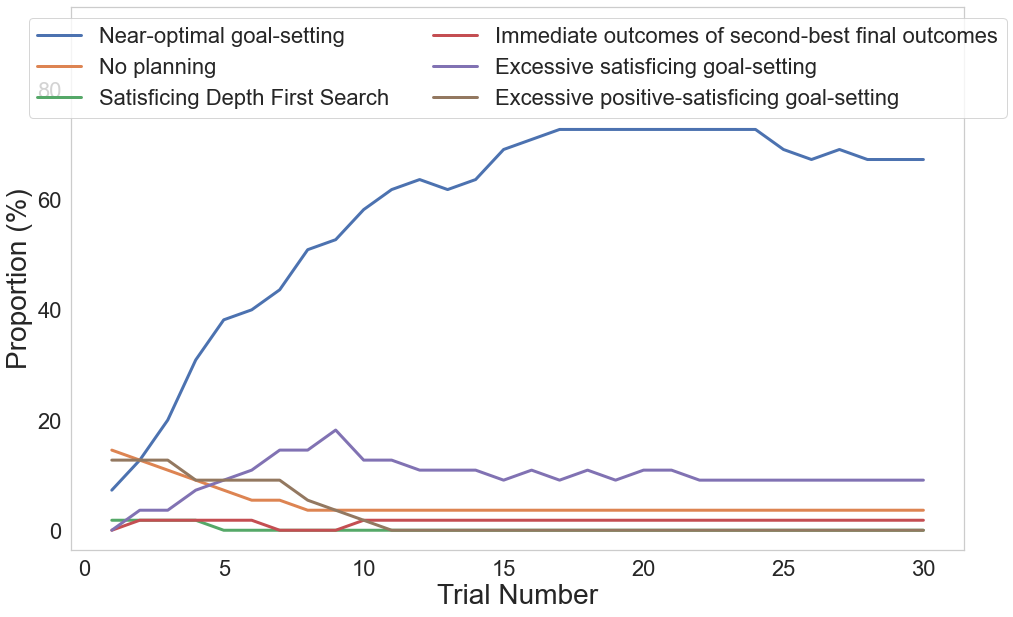

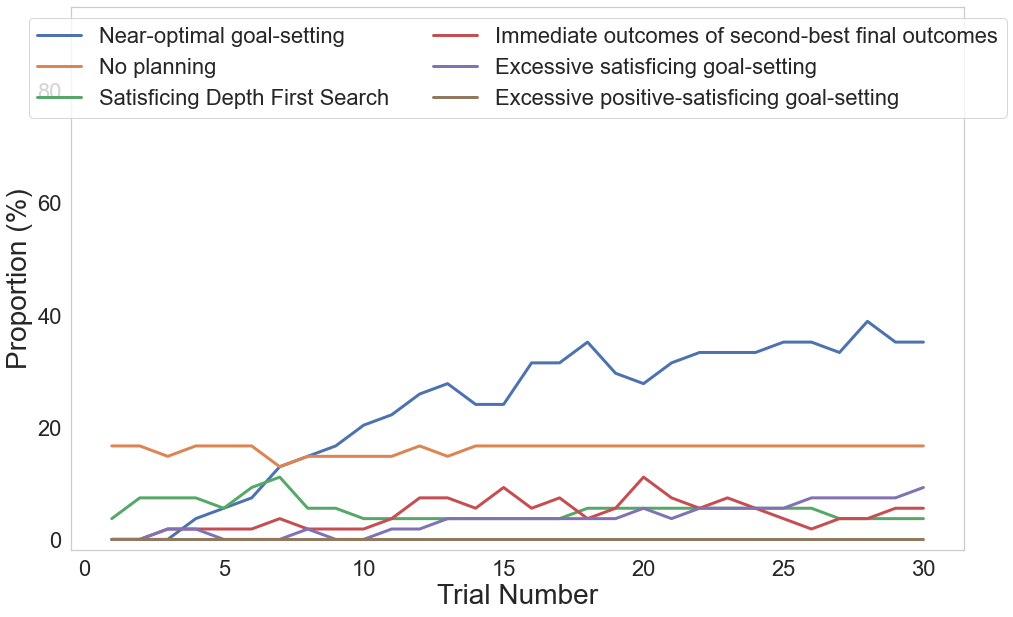

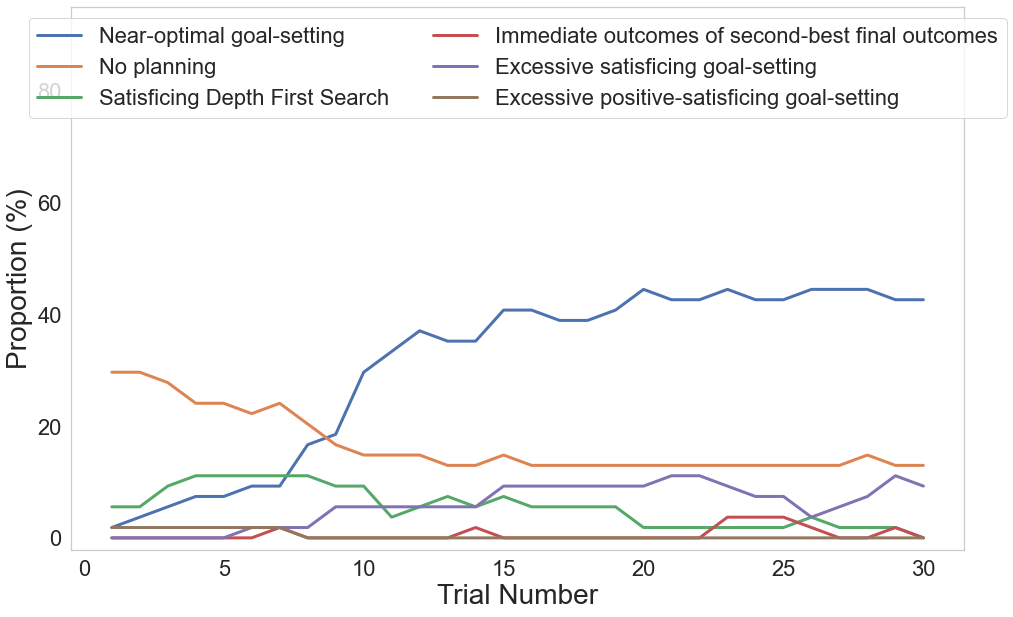

In [73]:
labels = ["Near-optimal goal-setting", "No planning", "Satisficing Depth First Search", "Immediate outcomes of second-best final outcomes", "Excessive satisficing goal-setting", "Excessive positive-satisficing goal-setting"]
conditions = ['meta', 'action', 'none']
print(sorted(list(strategies_set)))
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    exp.plot_strategy_proportions(S = sorted(list(strategies_set)), labels=labels, suffix=conditions[i])

### Plotting experiment wise clusters

In [74]:
k = 3
best_c = set()
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    exp.init_strategy_clusters(cluster_map)
    props = exp.get_cluster_proportions()
    sorted_props = sorted(props.items(), key=operator.itemgetter(1), reverse=True)
    for p in sorted_props[:k]:
        best_c.add(p[0])
best_c = sorted(list(best_c))
print(best_c)

[5, 7, 9, 10, 13]


In [75]:
best_c = [12, 5, 7, 9, 10, 13]

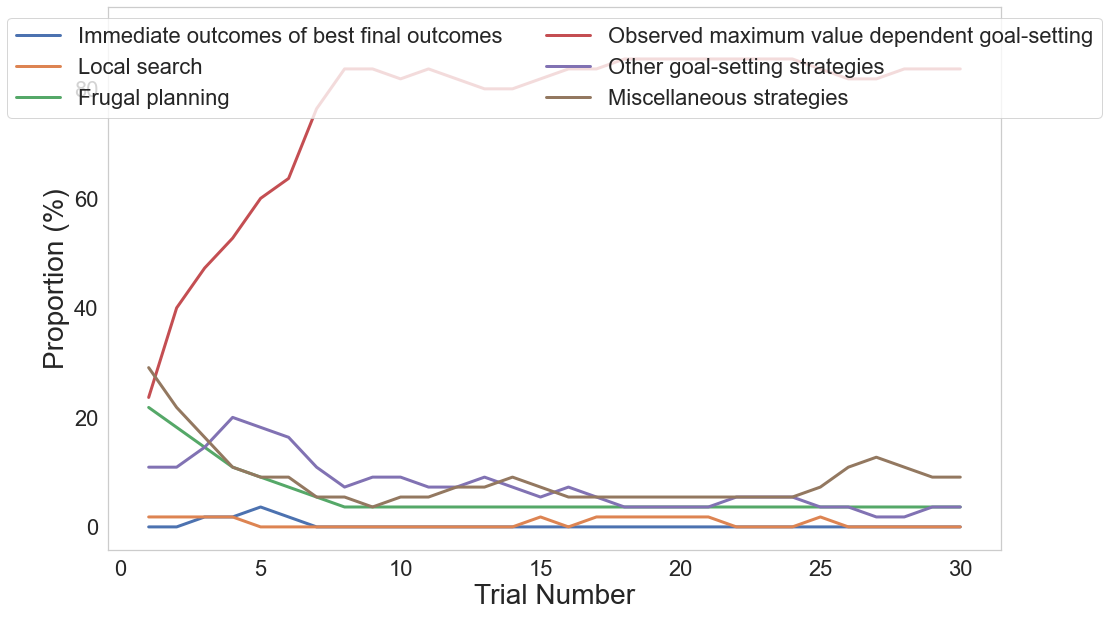

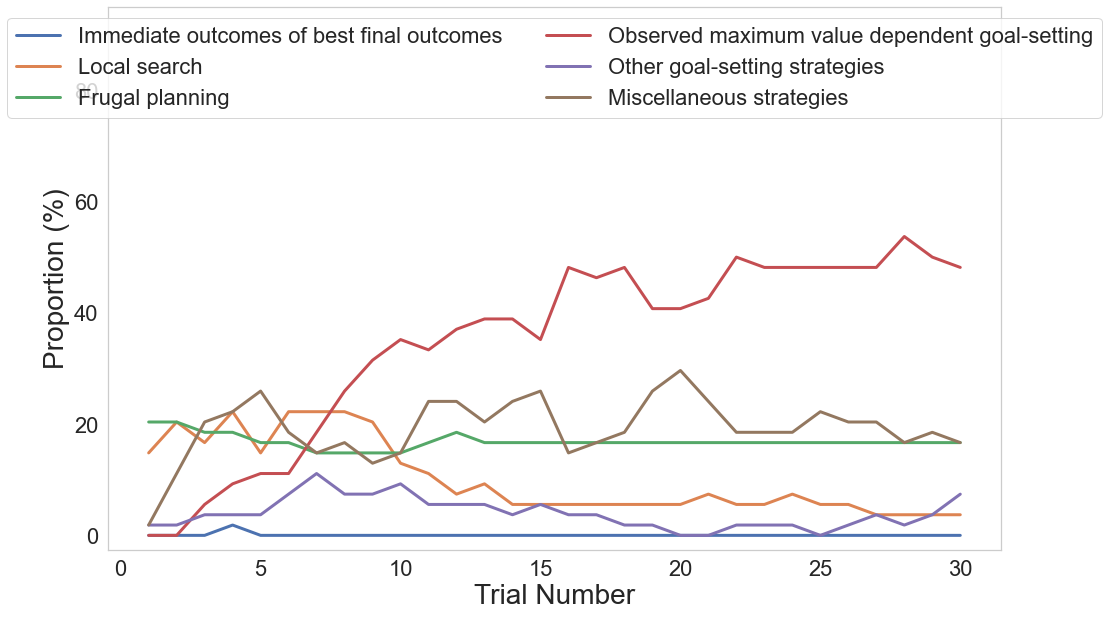

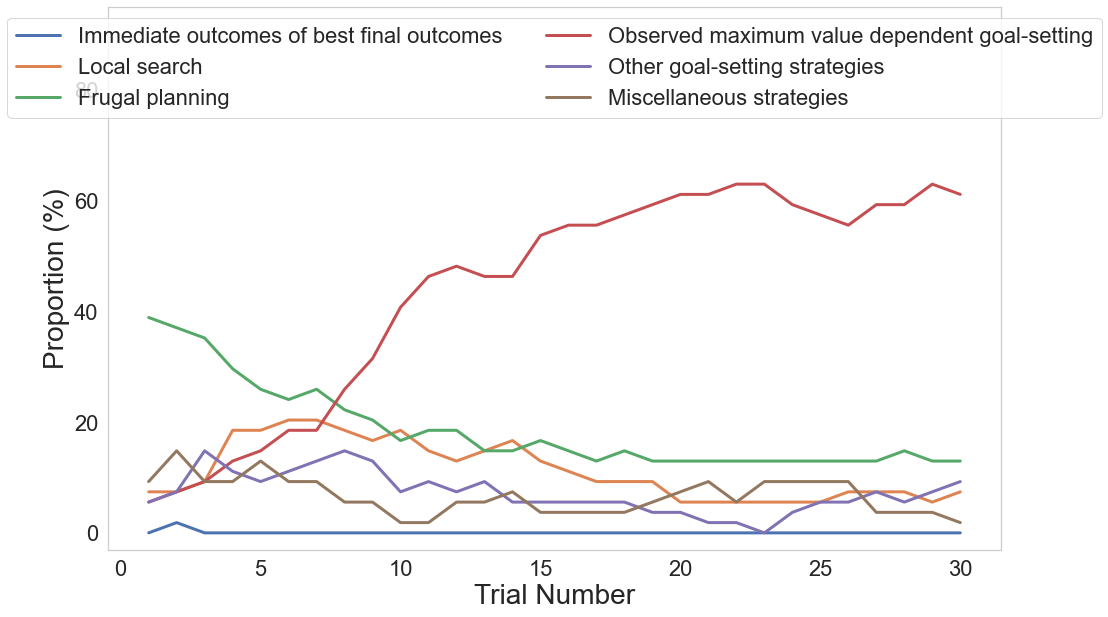

In [76]:
labels = ["Immediate outcomes of best final outcomes", "Local search", "Frugal planning", "Observed maximum value dependent goal-setting", "Other goal-setting strategies", "Miscellaneous strategies"]
conditions = ['meta', 'action', 'none']
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    exp.plot_cluster_proportions(C = best_c, suffix = conditions[i], labels=labels, combine_other=False)

In [77]:
k = 6
best_c = set()
for i, exp in enumerate([v1]):
    exp.init_strategy_clusters(cluster_map)
    props = exp.get_cluster_proportions()
    sorted_props = sorted(props.items(), key=operator.itemgetter(1), reverse=True)
    for p in sorted_props[:k]:
        best_c.add(p[0])
best_c = sorted(list(best_c))
print(best_c)

[5, 7, 8, 9, 10, 13]


In [78]:
best_c = [5, 7, 8, 9, 10, 13]

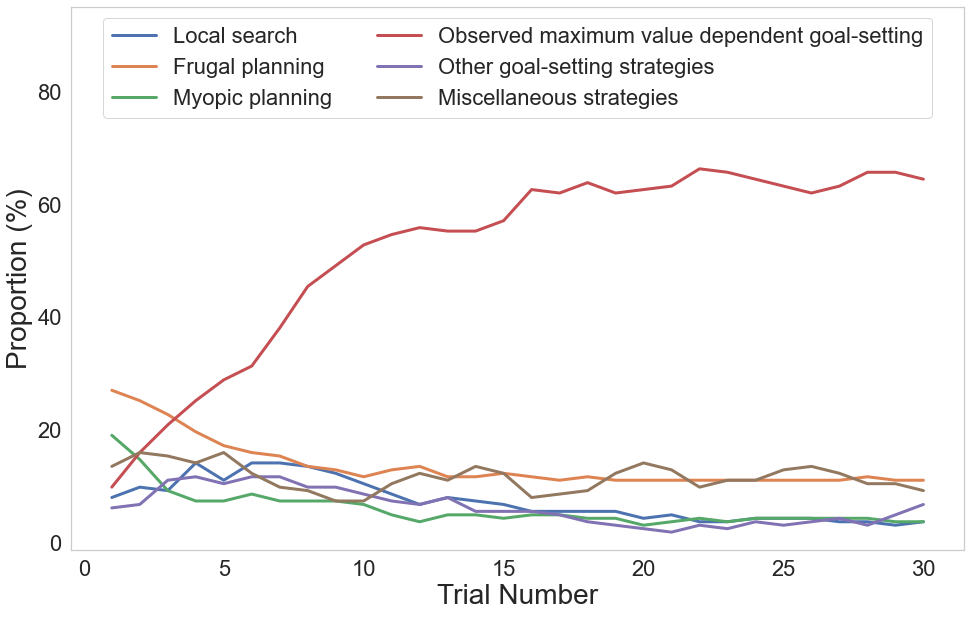

In [79]:
labels = ["Local search", "Frugal planning", "Myopic planning", "Observed maximum value dependent goal-setting", "Other goal-setting strategies", "Miscellaneous strategies"]
v1.plot_cluster_proportions(C = best_c, suffix = "total", labels=labels, combine_other=False)

### Comparing statistics across conditions

0 0.01575757575757576
0 0.5781818181818181
0 0.0496969696969697
1 0.1518518518518519
1 0.23518518518518522
1 0.16172839506172842
2 0.13950617283950617
2 0.30925925925925923
2 0.16666666666666666


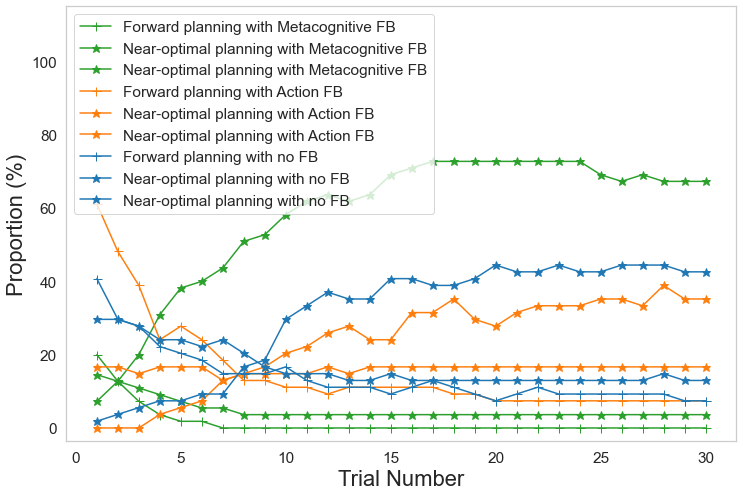

In [80]:
import matplotlib
forward_planning_strategies = [3, 10, 82, 5, 36, 37, 54, 79, 22, 23, 32, 33, 53, 64, 65, 69, 70, 80, 28, 34]
no_planning_strategies = [30]
goal_setting_strategies = [21]
conditions = ['Metacognitive FB', 'Action FB', 'No FB']
markers = ["*", "+", "o"]
forward_labels = ["Forward planning with Metacognitive FB", "Forward planning with Action FB", "Forward planning with no FB"]
goal_labels = ["Near-optimal planning with Metacognitive FB", "Near-optimal planning with Action FB", "Near-optimal planning with no FB"]
cmap = matplotlib.cm.get_cmap('tab10')
colors = [cmap(2), cmap(1), cmap(0)]
forward_freqs = {}
goal_setting_freqs = {}
no_planning_freqs = {}
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    s_props = exp.get_strategy_proportions(trial_wise=True)
    forward_freqs[conditions[i]] = np.sum([[s_props[t].get(s, 0) for t in sorted(s_props.keys())] for s in forward_planning_strategies], axis=0)
    goal_setting_freqs[conditions[i]] = np.sum([[s_props[t].get(s, 0) for t in sorted(s_props.keys())] for s in goal_setting_strategies], axis=0)
    no_planning_freqs[conditions[i]] = np.sum([[s_props[t].get(s, 0) for t in sorted(s_props.keys())] for s in no_planning_strategies], axis=0)
    print(i, np.mean(forward_freqs[conditions[i]]))
    print(i, np.mean(goal_setting_freqs[conditions[i]]))
    print(i, np.mean(no_planning_freqs[conditions[i]]))
plt.figure(figsize=(12, 8))
for c, condition in enumerate(conditions):
    plt.plot(range(1, 31), forward_freqs[condition]*100, marker = markers[1], color = colors[c], label=forward_labels[c], markersize=9)
    plt.plot(range(1, 31), goal_setting_freqs[condition]*100, marker = markers[0], color = colors[c], label=goal_labels[c], markersize=9)
    plt.plot(range(1, 31), no_planning_freqs[condition]*100, marker = markers[0], color = colors[c], label=goal_labels[c], markersize=9)
plt.legend()
plt.ylim(top=115)
plt.xlabel("Trial Number", fontsize=22)
plt.ylabel("Proportion (%)", fontsize=22)
plt.savefig("results/planning_conditions.pdf", bbox_inches='tight')

In [81]:
import matplotlib
forward_planning_strategies = [3, 10, 82, 5, 36, 37, 54, 79, 22, 23, 32, 33, 53, 64, 65, 69, 70, 80, 28, 34]
no_planning_strategies = [30]
goal_setting_strategies = [21]
forward_freqs = {}
goal_setting_freqs = {}
no_planning_freqs = {}
total = {}
for i, exp in enumerate([v1_meta, v1_action, v1_nofb]):
    s_freqs, total_f = exp.get_strategy_frequencies(exp.participant_strategies, trial_wise=True)
    forward_freqs[conditions[i]] = np.sum([[s_freqs[t].get(s, 0) for t in sorted(s_props.keys())] for s in forward_planning_strategies], axis=0)
    goal_setting_freqs[conditions[i]] = np.sum([[s_freqs[t].get(s, 0) for t in sorted(s_props.keys())] for s in goal_setting_strategies], axis=0)
    no_planning_freqs[conditions[i]] = np.sum([[s_freqs[t].get(s, 0) for t in sorted(s_props.keys())] for s in no_planning_strategies], axis=0)
    total[conditions[i]] = total_f

from scipy.stats import chi2_contingency
z, p = proportions_ztest([np.sum(goal_setting_freqs[conditions[0]]), np.sum(goal_setting_freqs[conditions[2]])], nobs=[np.sum(total[conditions[0]]), np.sum(total[conditions[2]])])
print(z, p)
z, p = proportions_ztest([np.sum(goal_setting_freqs[conditions[1]]), np.sum(goal_setting_freqs[conditions[2]])], nobs=[np.sum(total[conditions[1]]), np.sum(total[conditions[2]])])
print(z, p)

z, p = proportions_ztest([np.sum(forward_freqs[conditions[0]]), np.sum(forward_freqs[conditions[2]])], nobs=[np.sum(total[conditions[0]]), np.sum(total[conditions[2]])])
print(z, p)
z, p = proportions_ztest([np.sum(forward_freqs[conditions[1]]), np.sum(forward_freqs[conditions[2]])], nobs=[np.sum(total[conditions[1]]), np.sum(total[conditions[2]])])
print(z, p)

15.471441498259233 5.408229959097975e-54
-4.736391119961749 2.175575365609689e-06
-13.266420282477773 3.624873563195906e-40
0.9959750487029659 0.31926226859741946


### Plotting frequencies of decision systems

['Experiment', 'Trial', 'Decision System', 'Relative Influence (%)']


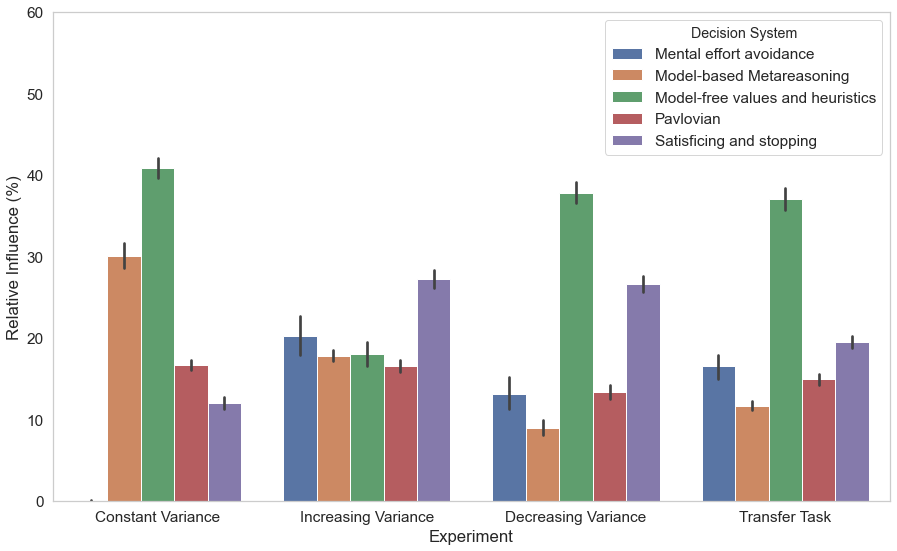

In [82]:
decision_system_labels = ["Mental effort avoidance", "Model-based Metareasoning", "Model-free values and heuristics",
                                "Pavlovian", "Satisficing and stopping"]
data_columns = ['Experiment', 'Trial', 'Decision System', 'Relative Influence (%)']
print(data_columns)
def get_ds_data(strategies, experiment_num):
    data = []
    for pid in strategies.keys():
        for i in range(len(strategies[pid])):
            for j in range(len(decision_system_labels)):
                data.append([experiment_num, i, decision_system_labels[j], DS_proportions[strategies[pid][i]-1][j]*100])
    return data
data = get_ds_data(c1_strategies, "Constant Variance")
data += get_ds_data(c2_inc_strategies, "Increasing Variance")
data += get_ds_data(c2_dec_strategies, "Decreasing Variance")
data += get_ds_data(T1_strategies, "Transfer Task")

df = pd.DataFrame(data, columns=data_columns)
plt.figure(figsize=(15, 9))
plt.ylim(top=60)
sns.barplot(x = "Experiment", y = "Relative Influence (%)", hue="Decision System", data=df)
plt.savefig("results/structure_influence_ds.pdf", bbox_inches='tight')

### Plotting frequencies of strategies

{65, 37, 70, 21, 22, 57, 30, 63}
[21, 22, 30, 37, 57, 63, 65, 70]


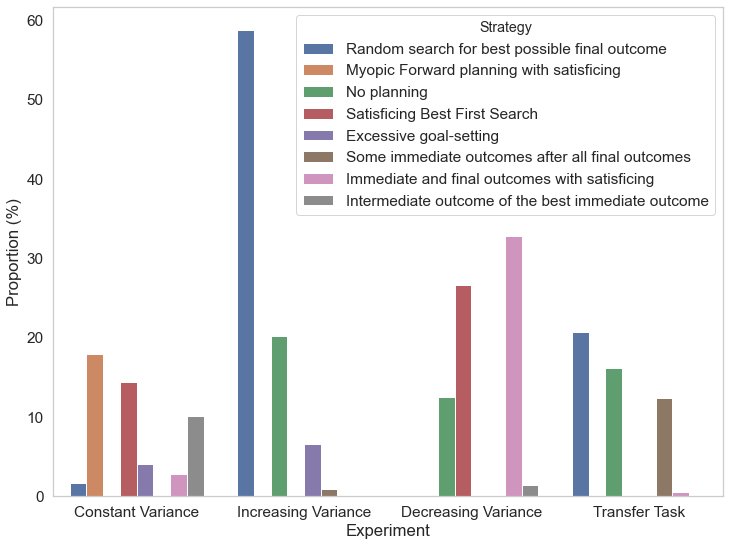

In [83]:
def get_strategy_proportions(strategies):
    S = []
    for s in strategies.values():
        if type(s) == list:
            S += s
    counts = Counter(S)
    total_counts = sum(counts.values())
    counts = {k: v/total_counts for k, v in counts.items()}
    return defaultdict(int, counts)

def get_top_k(counts, k=4):
    S = {c[0] for c in counts[:k]}
    return S
    
c1_counts = get_strategy_proportions(c1_strategies)
c2_inc_counts = get_strategy_proportions(c2_inc_strategies)
c2_dec_counts = get_strategy_proportions(c2_dec_strategies)
transfer_counts = get_strategy_proportions(T1_strategies)

reward_structure_counts = [c1_counts, c2_inc_counts, c2_dec_counts, transfer_counts]
strategies_set = set()
for counts in reward_structure_counts:
    strategies_set = strategies_set.union(get_top_k(sort_counts(counts), k=3))

print(strategies_set)
strategies_list = sorted(list(strategies_set))
print(strategies_list)

reward_structures = ['Constant Variance', 'Increasing Variance', 'Decreasing Variance', 'Transfer Task']
data = []
columns = ['Experiment', 'Strategy', 'Proportion (%)']
strategy_labels = ["Random search for best possible final outcome", "Myopic Forward planning with satisficing", "No planning", "Satisficing Best First Search", "Excessive goal-setting",
                  "Some immediate outcomes after all final outcomes", "Immediate and final outcomes with satisficing", "Intermediate outcome of the best immediate outcome"]
for i in range(len(reward_structures)):
    for strategy in strategies_list:
        data.append([reward_structures[i], strategy_labels[strategies_list.index(strategy)], reward_structure_counts[i][strategy]*100])
        #data.append([reward_structures[i], strategy, reward_structure_counts[i][strategy]*100])
df = pd.DataFrame(data, columns=columns)
plt.figure(figsize=(12, 9))
sns.barplot(x = 'Experiment', y='Proportion (%)', hue='Strategy', data=df)
plt.savefig("results/structure_influence_sprop.pdf", bbox_inches='tight')

### Plotting clusters of v1 and transfer task

Strategies for 7 not found. Skipping adding strategy data
Strategies for 28 not found. Skipping adding strategy data
Strategies for 45 not found. Skipping adding strategy data
Strategies for 46 not found. Skipping adding strategy data
Strategies for 72 not found. Skipping adding strategy data
Strategies for 89 not found. Skipping adding strategy data
Strategies for 95 not found. Skipping adding strategy data
Strategies for 97 not found. Skipping adding strategy data
Strategies for 104 not found. Skipping adding strategy data
Strategies for 107 not found. Skipping adding strategy data
Strategies for 132 not found. Skipping adding strategy data
Strategies for 143 not found. Skipping adding strategy data
Strategies for 150 not found. Skipping adding strategy data
[(9, 0.5171779141104295), (7, 0.13680981595092023), (13, 0.11533742331288344), (5, 0.07321063394683026), (10, 0.06237218813905931), (8, 0.05991820040899796), (4, 0.029243353783231084), (2, 0.0028629856850715747), (12, 0.001431492

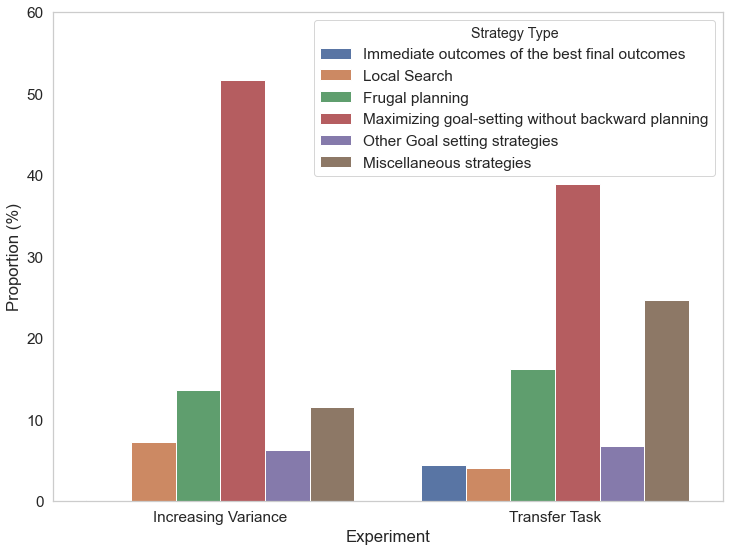

In [92]:
v1.infer_strategies(v1_strategies, show_pids=False)
T1.infer_strategies(T1_strategies, show_pids=False)
v1.init_strategy_clusters(cluster_map)
T1.init_strategy_clusters(cluster_map)
#v1.plot_cluster_proportions(C=list(range(1, 14)))
#T1.plot_cluster_proportions(C=list(range(1, 14)))
v1_proportions = get_strategy_proportions(v1.participant_clusters)
T1_proportions = get_strategy_proportions(T1.participant_clusters)
v1_cluster_counts = sort_counts(v1_proportions)
T1_cluster_counts = sort_counts(T1_proportions)
print(v1_cluster_counts, T1_cluster_counts)

k = 5
clusters_set = set()
for counts in [v1_cluster_counts, T1_cluster_counts]:
    for p in counts[:k]:
        clusters_set.add(p[0])
print(clusters_set)

cluster_list = sorted(list(clusters_set))
print(cluster_list)
cluster_list = [12, 5, 7, 9, 10, 13]
reward_structures = ['Increasing Variance', 'Transfer Task']
reward_structure_counts = [v1_proportions, T1_proportions]
data = []
columns = ['Experiment', 'Strategy Type', 'Proportion (%)']
cluster_labels = ["Immediate outcomes of the best final outcomes", "Local Search", "Frugal planning", "Maximizing goal-setting without backward planning", "Other Goal setting strategies", "Miscellaneous strategies"]
for i in range(len(reward_structures)):
    t_prop = 0
    for j, cluster in enumerate(cluster_list):
        data.append([reward_structures[i], cluster_labels[j], reward_structure_counts[i][cluster]*100])
        t_prop += reward_structure_counts[i][cluster]
    #data.append([reward_structures[i], cluster_labels[-1], (1- t_prop)*100])
df = pd.DataFrame(data, columns=columns)
plt.figure(figsize=(12, 9))
sns.barplot(x = 'Experiment', y='Proportion (%)', hue='Strategy Type', data=df)
plt.ylim(top = 60)
plt.savefig("results/cluster_transfer.pdf", bbox_inches='tight')

F1 Num strategies: 26
Strategies for 7 not found. Skipping adding strategy data
Strategies for 28 not found. Skipping adding strategy data
Strategies for 45 not found. Skipping adding strategy data
Strategies for 46 not found. Skipping adding strategy data
Strategies for 72 not found. Skipping adding strategy data
Strategies for 89 not found. Skipping adding strategy data
Strategies for 95 not found. Skipping adding strategy data
Strategies for 97 not found. Skipping adding strategy data
Strategies for 104 not found. Skipping adding strategy data
Strategies for 107 not found. Skipping adding strategy data
Strategies for 132 not found. Skipping adding strategy data
Strategies for 143 not found. Skipping adding strategy data
Strategies for 150 not found. Skipping adding strategy data
v1.0 Num strategies: 25
Strategies for 152 not found. Skipping adding strategy data
Strategies for 147 not found. Skipping adding strategy data
Strategies for 136 not found. Skipping adding strategy data
Str

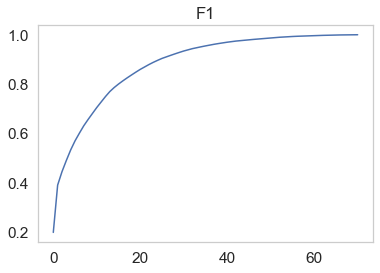

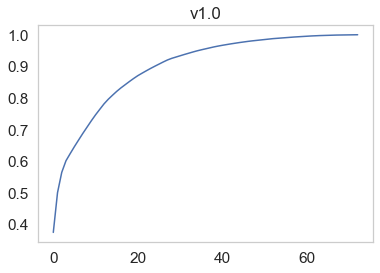

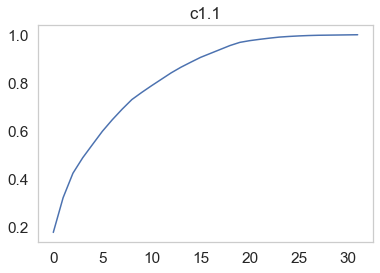

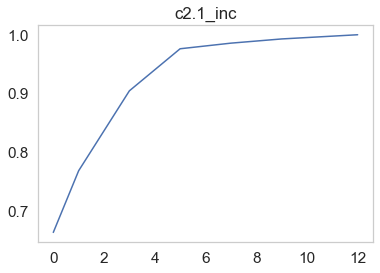

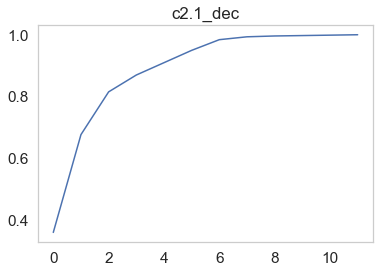

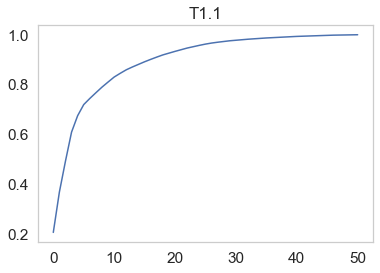

In [85]:
threshold = 0.90
exp_nums = ["F1", "v1.0", "c1.1", "c2.1_inc", "c2.1_dec", "T1.1"]
exps = [F1, v1, c1, c2_inc, c2_dec, T1]
strategies_set = set()
strategies = [F1_strategies, v1_strategies, c1_strategies, c2_inc_strategies, c2_dec_strategies, T1_strategies]
for exp_num, exp, S in zip(exp_nums, exps, strategies):
    exp.infer_strategies(precomputed_strategies=S, show_pids=False)
    strategy_proportions = exp.get_strategy_proportions()
    props = sorted(strategy_proportions.items(), key=operator.itemgetter(1), reverse=True)
    top_k_props = [p[1] for p in props]
    k_cumsum = np.cumsum(top_k_props)
    cutoff = 0
    for i, c in enumerate(k_cumsum):
        if c > threshold:
            cutoff = i
            break
    for p in props[:i+1]:
        strategies_set.add(p[0])
    print(exp_num, "Num strategies:", i+1)
    plt.figure()
    plt.title(exp_num)
    plt.plot(k_cumsum)
print(len(strategies_set))

In [87]:
def analyze_transitions(T):
    high_performing = 0
    low_performing = 0
    total = sum(T.values())
    for k, v in T.items():
        if strategy_scores[k[0]] < strategy_scores[k[1]]:
            high_performing += v
        elif strategy_scores[k[0]] > strategy_scores[k[1]]:
            low_performing += v
    print(high_performing, low_performing, total)
    print(high_performing/total, low_performing/total)
    print(proportions_chisquare(count=[high_performing, low_performing], nobs=[total, total]))

119 69 1566
0.07598978288633461 0.044061302681992334
(14.147057123034227, 0.00016906135329032432, (array([[ 119, 1447],
       [  69, 1497]]), array([[  94., 1472.],
       [  94., 1472.]])))
None


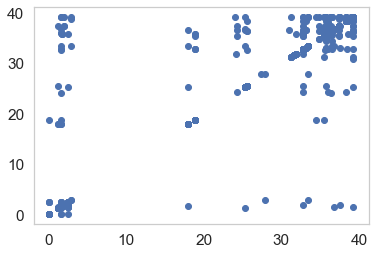

In [88]:
freqs = v1_nofb.get_transition_frequencies()
print(analyze_transitions(freqs))
fvs = []
svs = []
for k, v in freqs.items():
    fvs += [strategy_scores[k[0]]]*v
    svs += [strategy_scores[k[1]]]*v
plt.scatter(fvs, svs)

Strategies for 7 not found. Skipping adding strategy data
Strategies for 28 not found. Skipping adding strategy data
Strategies for 45 not found. Skipping adding strategy data
Strategies for 46 not found. Skipping adding strategy data
Strategies for 72 not found. Skipping adding strategy data
Strategies for 89 not found. Skipping adding strategy data
Strategies for 95 not found. Skipping adding strategy data
Strategies for 97 not found. Skipping adding strategy data
Strategies for 104 not found. Skipping adding strategy data
Strategies for 107 not found. Skipping adding strategy data
Strategies for 132 not found. Skipping adding strategy data
Strategies for 143 not found. Skipping adding strategy data
Strategies for 150 not found. Skipping adding strategy data
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 6

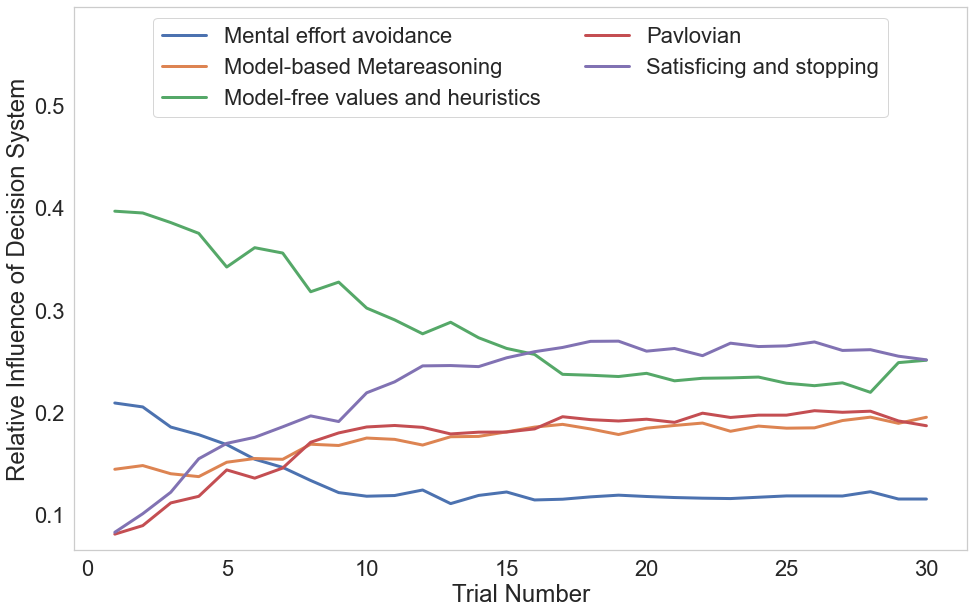

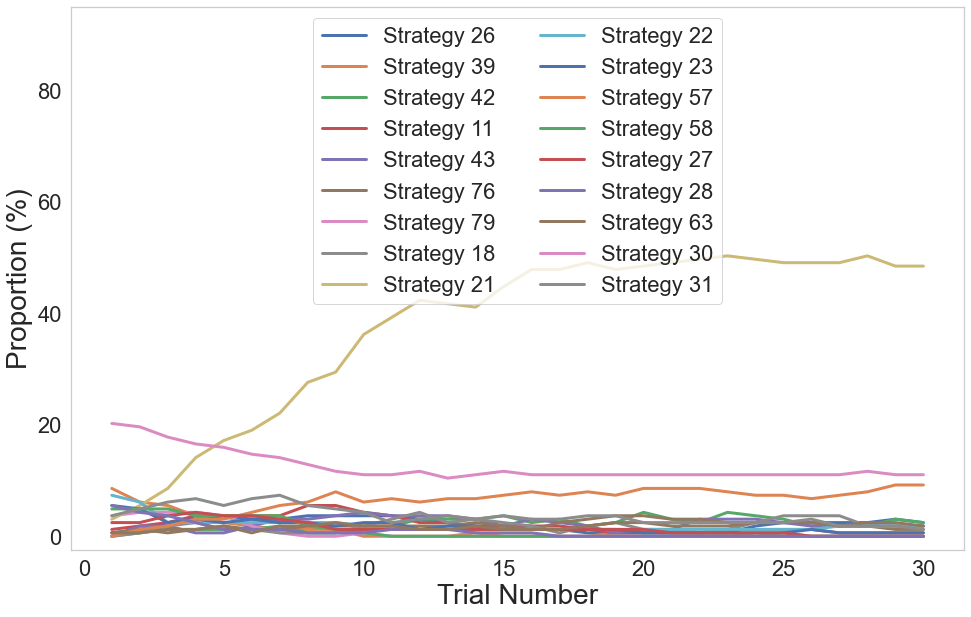

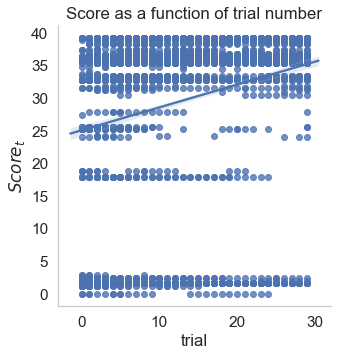

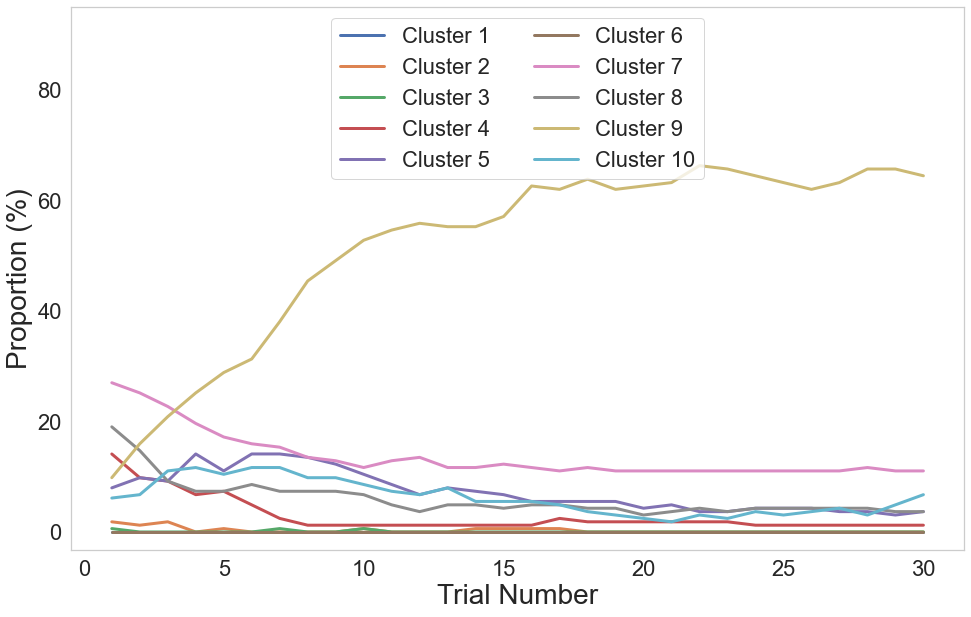

In [89]:
v1.summarize(features, normalized_features, strategy_weights, decision_systems, W_DS, DS_proportions, strategy_scores, cluster_scores, cluster_map, precomputed_strategies=v1_strategies, show_pids=False)

In [90]:
# E.plot_strategy_proportions(S = [21, 30])
uniform_strategies = pickle_load("results/uniform_prior_inferences/v1.0_strategies.pkl")
v1.infer_strategies(precomputed_strategies=uniform_strategies, show_pids = False)
transition_frequencies = v1.get_transition_frequencies()

Strategies for 28 not found. Skipping adding strategy data
Strategies for 45 not found. Skipping adding strategy data
Strategies for 89 not found. Skipping adding strategy data
Strategies for 95 not found. Skipping adding strategy data
Strategies for 97 not found. Skipping adding strategy data
Strategies for 104 not found. Skipping adding strategy data
Strategies for 107 not found. Skipping adding strategy data
Strategies for 150 not found. Skipping adding strategy data


### Chi2 test for showing that a random self transition is more probable than a random transition

Make sure to say that it is from the set of observed transitions and not from the set of all transitions

In [ ]:
self_transition_counts = []
transition_counts = []
for tr, k in transition_frequencies.items():
    if tr[0] != tr[1]:
        transition_counts.append(k)
    else:
        self_transition_counts.append(k)
print(self_transition_counts, transition_counts)

In [ ]:
t, p = ttest_ind(self_transition_counts, transition_counts)
print(np.round(t, 2), np.round(p, 4))
print(len(self_transition_counts) + len(transition_counts)-2)